In [1]:
import os
import numpy as np
import pandas as pd

url = "https://nft-capstone.s3.us-west-1.amazonaws.com/df_all_values.pkl.gz"
df_all_values = pd.read_pickle(url)

In [2]:
# needs to be run on google colab or device with gpu
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
os.getcwd()

'/content'

In [4]:
!pip install pytorch_tabnet

In [2]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')

# standard imports and setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats

# model evaluation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, ShuffleSplit
from sklearn.metrics import *

# pipelines
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline

# data preparation
from sklearn.preprocessing import *
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE, RFECV
from sklearn.utils import resample
from imblearn.datasets import make_imbalance
from imblearn.over_sampling import SMOTE

# machine learning
from sklearn.linear_model import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier, XGBRegressor
import lightgbm as lgb
# from catboost import CatBoostClassifier
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
import torchvision
from datetime import datetime

In [4]:
df_model_results = pd.read_pickle('https://storage.googleapis.com/nft_capstone_datafiles/df_model_results_tabnet.pkl')
# df_model_results_tabnet = pd.read_pickle('df_model_results_tabnet.pkl')

Predict whether secondary sales of NFTs will be higher or lower

In [ ]:
df_all_values['First_item_Unique_id_collection'].value_counts()

1    4678242
0    1392785
Name: First_item_Unique_id_collection, dtype: int64

In [ ]:
df_collection_nft_second = df_all_values[(df_all_values['First_item_Collection_cleaned'] == 0) & (df_all_values['First_item_Unique_id_collection'] == 0)]
df_collection_nft_second.head()

In [7]:
column_list = ['Price_USD','Price_increase','Category','Collection_cleaned','nft_sales_count', 'First_item_Unique_id_collection','GoogleTrends', 'BTC_price', 'ETH_price',
                               'MANA_price', 'WAX_price','GoogleTrends_7d_rolling_avg', 'GoogleTrends_14d_rolling_avg','GoogleTrends_30d_rolling_avg',
                               'GoogleTrends_60d_rolling_avg','GoogleTrends_90d_rolling_avg', 'BTC_price_7d_rolling_avg','BTC_price_14d_rolling_avg','BTC_price_30d_rolling_avg',
                               'BTC_price_60d_rolling_avg', 'BTC_price_90d_rolling_avg','ETH_price_7d_rolling_avg', 'ETH_price_14d_rolling_avg','ETH_price_30d_rolling_avg',
                               'ETH_price_60d_rolling_avg','ETH_price_90d_rolling_avg', 'MANA_price_7d_rolling_avg','MANA_price_14d_rolling_avg', 'MANA_price_30d_rolling_avg',
                               'MANA_price_60d_rolling_avg', 'MANA_price_90d_rolling_avg','WAX_price_7d_rolling_avg', 'WAX_price_14d_rolling_avg','WAX_price_30d_rolling_avg',
                               'WAX_price_60d_rolling_avg','WAX_price_90d_rolling_avg', 'Ggl_trends_collection','Ggl_trends_collection_7d_rolling_avg',
                               'Ggl_trends_collection_14d_rolling_avg','Ggl_trends_collection_30d_rolling_avg','Ggl_trends_collection_60d_rolling_avg',
                               'Ggl_trends_collection_90d_rolling_avg','Price_USD_median_7d', 'Price_USD_max_7d', 'Price_USD_median_14d','Price_USD_max_14d',
                               'Price_USD_median_30d', 'Price_USD_max_30d','Price_USD_median_60d', 'Price_USD_max_60d','Price_USD_median_90d', 'Price_USD_max_90d',
                               'Price_USD_median_180d','Price_USD_max_180d', 'Price_USD_median_365d', 'Price_USD_max_365d','Price_USD_median_730d','Price_USD_max_730d',
                               'Price_Crypto_median_7d','Price_Crypto_max_7d', 'Price_Crypto_median_14d','Price_Crypto_max_14d', 'Price_Crypto_median_30d',
                               'Price_Crypto_max_30d', 'Price_Crypto_median_60d','Price_Crypto_max_60d', 'Price_Crypto_median_90d','Price_Crypto_max_90d',
                               'Price_Crypto_median_180d','Price_Crypto_max_180d', 'Price_Crypto_median_365d','Price_Crypto_max_365d', 'Price_Crypto_median_730d',
                               'Price_Crypto_max_730d', 'Price_USD_collection_cum_median','Price_USD_collection_cum_max', 'Price_Crypto_collection_cum_median',
                               'Price_Crypto_collection_cum_max','p_resale', 'pca_1','pca_2', 'pca_3', 'pca_4', 'pca_5', 'trans_count_seller','deg_centrality_seller',
                               'pgrank_seller', 'trans_count_buyer', 'deg_centrality_buyer', 'pgrank_buyer']

drop_list = ['Price_USD','Price_increase', 'Collection_cleaned', 'Category_Utility'] 

fillna_median_list = ['p_resale', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5'] 
    
fillna_zero_list = ['Ggl_trends_collection', 'Ggl_trends_collection_7d_rolling_avg', 'Ggl_trends_collection_14d_rolling_avg', 'Ggl_trends_collection_30d_rolling_avg',
                    'Ggl_trends_collection_60d_rolling_avg', 'Ggl_trends_collection_90d_rolling_avg']

In [8]:
def get_x_and_y(df, fill_method):
    temp_df = df[column_list]
    if fill_method == 0:
        temp_df2 = temp_df.fillna(0)
    else:
        temp_df2 = temp_df.dropna(subset=['Price_USD'])
        for item in fillna_median_list:
            temp_df2[item] = temp_df2.groupby(['Collection_cleaned'], sort=False)[item].apply(lambda x: x.fillna(x.median()))
        for col in fillna_zero_list:
            temp_df2[col] = temp_df2[col].fillna(0)
        temp_df2 = temp_df2.bfill().ffill()
    temp_df3 = pd.get_dummies(temp_df2, columns=['Category'])
    temp_X = temp_df3.drop(columns=drop_list)
    temp_y = temp_df3['Price_increase']
    temp_indices = temp_X.index
    return temp_X, temp_y, temp_indices

In [9]:
# train, test, split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

def get_train_test_splits(X, y, indices):
    X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X,y,indices,test_size=0.2,random_state=20)
    return X_train, X_test, y_train, y_test, indices_train, indices_test

def get_scaled_train_test_splits(X, y, indices):
    X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X,y,indices,test_size=0.2,random_state=20)
    min_max_scaler = MinMaxScaler()
    X_train_scaled = min_max_scaler.fit_transform(X_train)
    X_test_scaled = min_max_scaler.fit_transform(X_test)
    return X_train_scaled, X_test_scaled, y_train, y_test, indices_train, indices_test

def get_balanced_train_test_splits(X, y, indices):
    X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X,y,indices,test_size=0.2,random_state=20)
    smote = SMOTE(random_state = 14)
    X_train2, y_train2 = smote.fit_resample(X_train, y_train)
    return X_train2, X_test, y_train2, y_test, indices_train, indices_test

def get_balanced_scaled_train_test_splits(X, y, indices):
    X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X,y,indices,test_size=0.2,random_state=20)
    smote = SMOTE(random_state = 14)
    X_train2, y_train2 = smote.fit_resample(X_train, y_train)
    min_max_scaler = MinMaxScaler()
    X_train_scaled = min_max_scaler.fit_transform(X_train2)
    X_test_scaled = min_max_scaler.fit_transform(X_test)
    return X_train_scaled, X_test_scaled, y_train2, y_test, indices_train, indices_test

In [11]:
def get_model_results(model, X_train, y_train, X_test, y_test, y_pred):
    train_acc_score = model.score(X_train, y_train)
    test_acc_score = model.score(X_test, y_test)
    bal_acc_score = balanced_accuracy_score(y_test, y_pred)
    temp_f1_score = f1_score(y_test, y_pred)
    temp_precision_score = precision_score(y_test, y_pred)
    temp_recall_score = recall_score(y_test, y_pred)
    temp_roc_auc_score = roc_auc_score(y_test, y_pred)
    return train_acc_score, test_acc_score, bal_acc_score, temp_f1_score, temp_precision_score, temp_recall_score, temp_roc_auc_score

def get_model_results2(model, X_train, y_train, X_test, y_test, y_pred):
    # train_acc_score = model.score(X_train, y_train)
    # test_acc_score = model.score(X_test, y_test)
    bal_acc_score = balanced_accuracy_score(y_test, y_pred)
    temp_f1_score = f1_score(y_test, y_pred)
    temp_precision_score = precision_score(y_test, y_pred)
    temp_recall_score = recall_score(y_test, y_pred)
    temp_roc_auc_score = roc_auc_score(y_test, y_pred)
    return bal_acc_score, temp_f1_score, temp_precision_score, temp_recall_score, temp_roc_auc_score

In [12]:
def write_model_results(model, model_description):
    model_results_dict[model_description] = {'model_scope': model_scope, 'model_type': model, 'balance_method': balance_method, 
                                                                   'scale_method': scale_method, 'train_acc_score': train_acc_score, 'test_acc_score': test_acc_score, 
                                                                   'balance_acc_score': bal_acc_score, 'f1_score': clf_f1_score, 'precision_score': clf_precision_score, 
                                                                   'recall_score': clf_recall_score, 'roc_auc_score': clf_roc_auc_score, 'confusion_matrix': CLF_cm, 
                                                                   'classification_report': CLF_cr, 'features': X.columns, 'coef_values': np.squeeze(model.coef_), 
                                                                   'date_recorded': datetime.today().strftime('%Y-%m-%d-%H:%M:%S')}

def write_model_results_2(model, model_description):
    model_results_dict[model_description] = {'model_scope': model_scope, 'model_type': model, 'balance_method': balance_method, 
                                                                   'scale_method': scale_method, 'train_acc_score': train_acc_score, 'test_acc_score': test_acc_score, 
                                                                   'balance_acc_score': bal_acc_score, 'f1_score': clf_f1_score, 'precision_score': clf_precision_score, 
                                                                   'recall_score': clf_recall_score, 'roc_auc_score': clf_roc_auc_score, 'confusion_matrix': CLF_cm, 
                                                                   'classification_report': CLF_cr, 'features': X.columns, 'coef_values': np.squeeze(model.feature_importances_), 
                                                                   'date_recorded': datetime.today().strftime('%Y-%m-%d-%H:%M:%S')}

def write_model_results_3(model, model_description):
    model_results_dict[model_description] = {'model_scope': model_scope, 'model_type': model, 'balance_method': balance_method, 
                                                                   'scale_method': scale_method, 
                                                                   'balance_acc_score': bal_acc_score, 'f1_score': clf_f1_score, 'precision_score': clf_precision_score, 
                                                                   'recall_score': clf_recall_score, 'roc_auc_score': clf_roc_auc_score,  
                                                                   'classification_report': CLF_cr, 'features': X.columns, 'coef_values': np.squeeze(model.feature_importances_), 
                                                                   'date_recorded': datetime.today().strftime('%Y-%m-%d-%H:%M:%S')}

In [13]:
# model_results_dict = {}
df_model_results2 = df_model_results.set_index('unique_model_name')
model_results_dict = df_model_results2.to_dict('index')
model_results_dict.keys()

dict_keys(['secondary-tabnet-fill0-nobal-noscale', 'secondary-tabnet-fill0-nobal-minmaxscale', 'secondary-tabnet-fillcustom-nobal-noscale', 'secondary-tabnet-fillcustom-nobal-minmaxscale', 'secondary2-49-tabnet-fill0-nobal-noscale', 'secondary2-49-tabnet-fill0-nobal-minmaxscale', 'secondary2-49-tabnet-fillcustom-nobal-noscale'])

In [14]:
df_model_results2

,model_scope,model_type,balance_method,scale_method,balance_acc_score,f1_score,precision_score,recall_score,roc_auc_score,classification_report,features,coef_values,date_recorded
unique_model_name,,,,,,,,,,,,,
secondary-tabnet-fill0-nobal-noscale,NFT secondary sales,"TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamm...",None,None,0.802719,0.796347,0.781445,0.811828,0.802719,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[0.212438048620167, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",2022-04-08-14:02:12
secondary-tabnet-fill0-nobal-minmaxscale,NFT secondary sales,"TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamm...",None,MinMaxScaler,0.781621,0.763385,0.797858,0.731768,0.781621,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[0.16480028167624844, 0.002095364407039438, 0....",2022-04-08-14:39:00
secondary-tabnet-fillcustom-nobal-noscale,NFT secondary sales,"TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamm...",None,None,0.799041,0.796655,0.764822,0.831254,0.799041,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[0.13950349445035315, 0.010005813196791297, 0....",2022-04-08-15:39:58
secondary-tabnet-fillcustom-nobal-minmaxscale,NFT secondary sales,"TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamm...",None,MinMaxScaler,0.802552,0.802931,0.758351,0.85308,0.802552,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[0.09678208083604772, 0.07243406087793339, 3.3...",2022-04-08-17:44:21
secondary2-49-tabnet-fill0-nobal-noscale,NFT sales 2-49,"TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamm...",None,None,0.886272,0.790118,0.675588,0.951406,0.886272,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[6.883974770867169e-06, 0.3785931395110315, 0....",2022-04-08-22:35:07
secondary2-49-tabnet-fill0-nobal-minmaxscale,NFT sales 2-49,"TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamm...",None,MinMaxScaler,0.882781,0.797153,0.70679,0.914009,0.882781,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[0.018010688900602142, 5.845171129589193e-13, ...",2022-04-09-03:25:16
secondary2-49-tabnet-fillcustom-nobal-noscale,NFT sales 2-49,"TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamm...",None,None,0.89426,0.805723,0.701573,0.946188,0.89426,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[0.0, 0.8238901407066395, 0.0, 0.0, 0.0, 0.0, ...",2022-04-09-17:24:41


TabNet - FillNA=0, Unbalanced, Unscaled

In [ ]:
# model characteristics to record with results
model_scope = 'NFT secondary sales'
# model_type = use CLF_model
fillna_method = 'Fill NaNs with zeroes'
balance_method = 'None'
scale_method = 'None'

In [ ]:
X, y, indices = get_x_and_y(df_collection_nft_second, 0)
print(len(X), len(y), len(indices))

1392785 1392785 1392785


In [ ]:
X_train, X_test, y_train, y_test, indices_train, indices_test = get_train_test_splits(X, y, indices)
print(len(X_train), len(X_test), len(y_train), len(y_test), len(indices_train), len(indices_test))

1114228 278557 1114228 278557 1114228 278557


In [ ]:
tabnet_params = {"optimizer_fn":torch.optim.Adam,
                 "optimizer_params":dict(lr=2e-2),
                 "scheduler_params":{"step_size":50, # how to use learning rate scheduler
                                 "gamma":0.9},
                 "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                 "mask_type":'entmax' # "sparsemax"
                }

CLF_model = TabNetClassifier(**tabnet_params
                      )

Device used : cuda


In [ ]:
max_epochs = 50 if not os.getenv("CI", False) else 2

In [ ]:
# This illustrates the warm_start=False behaviour
save_history = []
for _ in range(2):
    CLF_model.fit(
        X_train=X_train.values, y_train=y_train.values,
        eval_set=[(X_train.values, y_train.values), (X_test.values, y_test.values)],
        eval_name=['train', 'test'],
        eval_metric=['accuracy', 'balanced_accuracy', 'auc', 'logloss'],
        max_epochs=max_epochs , patience=20,
        batch_size=1024, virtual_batch_size=128,
        num_workers=0,
        weights=1,
        drop_last=False,
        #augmentations=aug, #aug, None
    )
    save_history.append(CLF_model.history["test_accuracy", "test_bal_accuracy", "test_auc", "test_logloss"])

assert(np.all(np.array(save_history[0]==np.array(save_history[1]))))

epoch 0  | loss: 0.47091 | train_accuracy: 0.78576 | train_balanced_accuracy: 0.78773 | train_auc: 0.86568 | train_logloss: 0.45534 | test_accuracy: 0.78572 | test_balanced_accuracy: 0.78776 | test_auc: 0.86575 | test_logloss: 0.4552  |  0:01:18s
epoch 1  | loss: 0.45105 | train_accuracy: 0.78846 | train_balanced_accuracy: 0.78776 | train_auc: 0.86998 | train_logloss: 0.45092 | test_accuracy: 0.78794 | test_balanced_accuracy: 0.78728 | test_auc: 0.86992 | test_logloss: 0.45087 |  0:02:24s
epoch 2  | loss: 0.44539 | train_accuracy: 0.79231 | train_balanced_accuracy: 0.79203 | train_auc: 0.8763  | train_logloss: 0.43896 | test_accuracy: 0.79306 | test_balanced_accuracy: 0.79288 | test_auc: 0.87656 | test_logloss: 0.43851 |  0:03:30s
epoch 3  | loss: 0.44161 | train_accuracy: 0.79115 | train_balanced_accuracy: 0.79423 | train_auc: 0.87804 | train_logloss: 0.43772 | test_accuracy: 0.79079 | test_balanced_accuracy: 0.79386 | test_auc: 0.87805 | test_logloss: 0.43771 |  0:04:35s
epoch 4  | l

KeyError: ignored

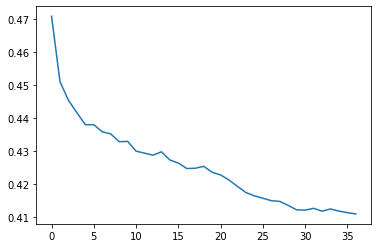

In [ ]:
# plot losses
plt.plot(CLF_model.history['loss'])

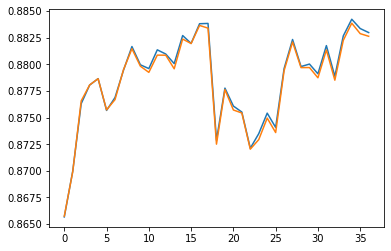

In [ ]:
# plot auc
plt.plot(CLF_model.history['train_auc'])
plt.plot(CLF_model.history['test_auc'])

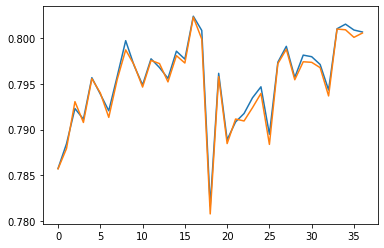

In [ ]:
# plot accuracy
plt.plot(CLF_model.history['train_accuracy'])
plt.plot(CLF_model.history['test_accuracy'])

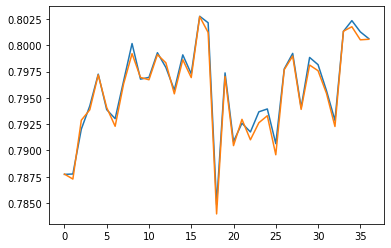

In [ ]:
# plot accuracy
plt.plot(CLF_model.history['train_balanced_accuracy'])
plt.plot(CLF_model.history['test_balanced_accuracy'])

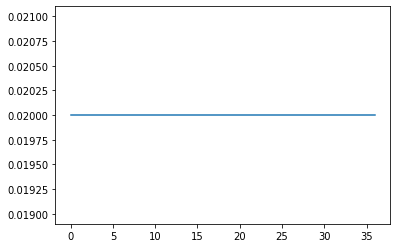

In [ ]:
# plot learning rates
plt.plot(CLF_model.history['lr'])

In [ ]:
preds = CLF_model.predict_proba(X_test.values)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test.values.reshape(-1,1))

In [ ]:
print(f"BEST VALID SCORE FOR : {CLF_model.best_cost}")
print(f"FINAL TEST SCORE FOR : {test_auc}")

BEST VALID SCORE FOR : 0.4285534903644263
FINAL TEST SCORE FOR : 0.8836331623966166


In [ ]:
# print('Training accuracy {:.4f}'.format(CLF_model.score(X_train.values,y_train.values.reshape(-1,1))))
# print('Testing accuracy {:.4f}'.format(CLF_model.score(X_test.values,y_test.values.reshape(-1,1))))
print(classification_report(y_test.values.reshape(-1,1),CLF_model.predict(X_test.values)))
# print(plot_confusion_matrix(CLF_model,X_test.values,y_test.values.reshape(-1,1),cmap='Blues_r'))
pd.DataFrame({'Value':CLF_model.feature_importances_,'Feature':X.columns}).sort_values(by="Value",ascending=False).head(15)

              precision    recall  f1-score   support

           0       0.82      0.79      0.81    145918
           1       0.78      0.81      0.80    132639

    accuracy                           0.80    278557
   macro avg       0.80      0.80      0.80    278557
weighted avg       0.80      0.80      0.80    278557



,Value,Feature
0,0.212438,nft_sales_count
81,0.152774,deg_centrality_seller
18,0.098391,ETH_price_14d_rolling_avg
86,0.071582,Category_Art
74,0.066164,p_resale
24,0.061471,MANA_price_30d_rolling_avg
44,0.061154,Price_USD_median_60d
88,0.046845,Category_Games
25,0.038311,MANA_price_60d_rolling_avg
6,0.030331,WAX_price


In [ ]:
print(CLF_model.best_cost)

0.4285534903644263


In [ ]:
y_pred = CLF_model.predict(X_test.values)

In [ ]:
def get_model_results2(model, X_train, y_train, X_test, y_test, y_pred):
    # train_acc_score = model.score(X_train, y_train)
    # test_acc_score = model.score(X_test, y_test)
    bal_acc_score = balanced_accuracy_score(y_test, y_pred)
    temp_f1_score = f1_score(y_test, y_pred)
    temp_precision_score = precision_score(y_test, y_pred)
    temp_recall_score = recall_score(y_test, y_pred)
    temp_roc_auc_score = roc_auc_score(y_test, y_pred)
    return bal_acc_score, temp_f1_score, temp_precision_score, temp_recall_score, temp_roc_auc_score

In [ ]:
bal_acc_score, clf_f1_score, clf_precision_score, clf_recall_score, clf_roc_auc_score = get_model_results2(CLF_model, X_train, y_train, X_test, y_test, y_pred)
print("balanced_acc_score: ", bal_acc_score)
print("f1_score: ", clf_f1_score)
print("precision_score: ", clf_precision_score)
print("recall_score: ", clf_recall_score)
print("roc_auc_score: ", clf_roc_auc_score)

balanced_acc_score:  0.8027188509869996
f1_score:  0.7963466267310074
precision_score:  0.7814450346889605
recall_score:  0.8118275921863102
roc_auc_score:  0.8027188509869997


In [ ]:
CLF_cr = classification_report(y_test,y_pred)
print(CLF_cr)

              precision    recall  f1-score   support

           0       0.82      0.79      0.81    145918
           1       0.78      0.81      0.80    132639

    accuracy                           0.80    278557
   macro avg       0.80      0.80      0.80    278557
weighted avg       0.80      0.80      0.80    278557



In [ ]:
pd.DataFrame({'Value':np.squeeze(CLF_model.feature_importances_),'Feature':X.columns}).sort_values(by="Value",ascending=False).head(15)

,Value,Feature
0,0.212438,nft_sales_count
81,0.152774,deg_centrality_seller
18,0.098391,ETH_price_14d_rolling_avg
86,0.071582,Category_Art
74,0.066164,p_resale
24,0.061471,MANA_price_30d_rolling_avg
44,0.061154,Price_USD_median_60d
88,0.046845,Category_Games
25,0.038311,MANA_price_60d_rolling_avg
6,0.030331,WAX_price


In [ ]:
write_model_results_3(CLF_model, 'secondary-tabnet-fill0-nobal-noscale')
model_results_dict.keys()

dict_keys(['secondary-tabnet-fill0-nobal-noscale'])

In [ ]:
df_model_results = pd.DataFrame(model_results_dict).transpose().reset_index().rename(columns={'index':'unique_model_name'})
print(len(df_model_results))
df_model_results.head()

1


,unique_model_name,balance_acc_score,balance_method,classification_report,coef_values,date_recorded,f1_score,features,model_scope,model_type,precision_score,recall_score,roc_auc_score,scale_method
0,secondary-tabnet-fill0-nobal-noscale,0.802719,None,precision recall f1-score ...,"[0.212438048620167, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",2022-04-08-14:02:12,0.796347,"Index(['nft_sales_count', 'First_item_Unique_i...",NFT secondary sales,"TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamm...",0.781445,0.811828,0.802719,None


In [ ]:
df_model_results.to_pickle('/content/drive/My Drive/df_model_results_tabnet.pkl')

TabNet - FillNA=0, Unbalanced, Scaled

In [ ]:
# model characteristics to record with results
model_scope = 'NFT secondary sales'
# model_type = use CLF_model
fillna_method = 'Fill NaNs with zeroes'
balance_method = 'None'
scale_method = 'MinMaxScaler'

In [ ]:
X, y, indices = get_x_and_y(df_collection_nft_second, 0)
print(len(X), len(y), len(indices))

1392785 1392785 1392785


In [ ]:
X_train, X_test, y_train, y_test, indices_train, indices_test = get_scaled_train_test_splits(X, y, indices)
print(len(X_train), len(X_test), len(y_train), len(y_test), len(indices_train), len(indices_test))

1114228 278557 1114228 278557 1114228 278557


In [ ]:
tabnet_params = {"optimizer_fn":torch.optim.Adam,
                 "optimizer_params":dict(lr=2e-2),
                 "scheduler_params":{"step_size":50, # how to use learning rate scheduler
                                 "gamma":0.9},
                 "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                 "mask_type":'entmax' # "sparsemax"
                }

CLF_model = TabNetClassifier(**tabnet_params
                      )

Device used : cuda


In [ ]:
max_epochs = 50 if not os.getenv("CI", False) else 2

In [ ]:
# This illustrates the warm_start=False behaviour
save_history = []
for _ in range(2):
    CLF_model.fit(
        X_train=X_train, y_train=y_train.values,
        eval_set=[(X_train, y_train.values), (X_test, y_test.values)],
        eval_name=['train', 'test'],
        eval_metric=['accuracy', 'balanced_accuracy', 'auc', 'logloss'],
        max_epochs=max_epochs , patience=20,
        batch_size=1024, virtual_batch_size=128,
        num_workers=0,
        weights=1,
        drop_last=False,
        #augmentations=aug, #aug, None
    )
    save_history.append(CLF_model.history["test_accuracy", "test_bal_accuracy", "test_auc", "test_logloss"])

assert(np.all(np.array(save_history[0]==np.array(save_history[1]))))

epoch 0  | loss: 0.47421 | train_accuracy: 0.78505 | train_balanced_accuracy: 0.78447 | train_auc: 0.86825 | train_logloss: 0.45139 | test_accuracy: 0.78456 | test_balanced_accuracy: 0.78441 | test_auc: 0.86844 | test_logloss: 0.45128 |  0:01:05s
epoch 1  | loss: 0.45201 | train_accuracy: 0.77991 | train_balanced_accuracy: 0.77699 | train_auc: 0.87005 | train_logloss: 0.45552 | test_accuracy: 0.77862 | test_balanced_accuracy: 0.77633 | test_auc: 0.86854 | test_logloss: 0.45641 |  0:02:09s
epoch 2  | loss: 0.44379 | train_accuracy: 0.78222 | train_balanced_accuracy: 0.77945 | train_auc: 0.87378 | train_logloss: 0.45126 | test_accuracy: 0.784   | test_balanced_accuracy: 0.78162 | test_auc: 0.87447 | test_logloss: 0.44929 |  0:03:14s
epoch 3  | loss: 0.43392 | train_accuracy: 0.78393 | train_balanced_accuracy: 0.78256 | train_auc: 0.86873 | train_logloss: 0.47018 | test_accuracy: 0.78371 | test_balanced_accuracy: 0.78256 | test_auc: 0.86898 | test_logloss: 0.46945 |  0:04:19s
epoch 4  | l

KeyError: ignored

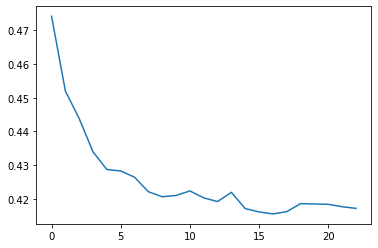

In [ ]:
# plot losses
plt.plot(CLF_model.history['loss'])

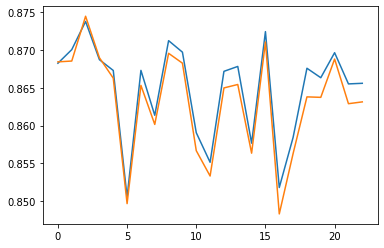

In [ ]:
# plot auc
plt.plot(CLF_model.history['train_auc'])
plt.plot(CLF_model.history['test_auc'])

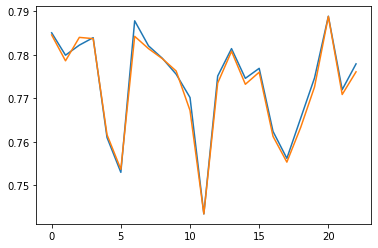

In [ ]:
# plot accuracy
plt.plot(CLF_model.history['train_accuracy'])
plt.plot(CLF_model.history['test_accuracy'])

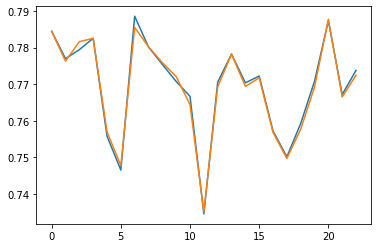

In [ ]:
# plot accuracy
plt.plot(CLF_model.history['train_balanced_accuracy'])
plt.plot(CLF_model.history['test_balanced_accuracy'])

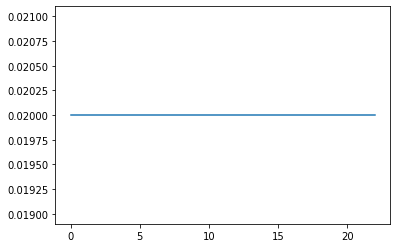

In [ ]:
# plot learning rates
plt.plot(CLF_model.history['lr'])

In [ ]:
preds = CLF_model.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test.values.reshape(-1,1))

In [ ]:
print(f"BEST VALID SCORE FOR : {CLF_model.best_cost}")
print(f"FINAL TEST SCORE FOR : {test_auc}")

BEST VALID SCORE FOR : 0.44928970121364187
FINAL TEST SCORE FOR : 0.8744719589883736


In [ ]:
# print('Training accuracy {:.4f}'.format(CLF_model.score(X_train.values,y_train.values.reshape(-1,1))))
# print('Testing accuracy {:.4f}'.format(CLF_model.score(X_test.values,y_test.values.reshape(-1,1))))
print(classification_report(y_test.values.reshape(-1,1),CLF_model.predict(X_test)))
# print(plot_confusion_matrix(CLF_model,X_test,y_test.values.reshape(-1,1),cmap='Blues_r'))
pd.DataFrame({'Value':CLF_model.feature_importances_,'Feature':X.columns}).sort_values(by="Value",ascending=False).head(15)

              precision    recall  f1-score   support

           0       0.77      0.83      0.80    145918
           1       0.80      0.73      0.76    132639

    accuracy                           0.78    278557
   macro avg       0.79      0.78      0.78    278557
weighted avg       0.78      0.78      0.78    278557



,Value,Feature
0,0.164800,nft_sales_count
12,0.115140,BTC_price_7d_rolling_avg
82,0.073512,pgrank_seller
73,0.061598,Price_Crypto_collection_cum_max
10,0.059009,GoogleTrends_60d_rolling_avg
75,0.053460,pca_1
26,0.036784,MANA_price_90d_rolling_avg
81,0.032542,deg_centrality_seller
76,0.031209,pca_2
14,0.029720,BTC_price_30d_rolling_avg


In [ ]:
print(CLF_model.best_cost)

0.44928970121364187


In [ ]:
y_pred = CLF_model.predict(X_test)

In [ ]:
bal_acc_score, clf_f1_score, clf_precision_score, clf_recall_score, clf_roc_auc_score = get_model_results2(CLF_model, X_train, y_train, X_test, y_test, y_pred)
print("balanced_acc_score: ", bal_acc_score)
print("f1_score: ", clf_f1_score)
print("precision_score: ", clf_precision_score)
print("recall_score: ", clf_recall_score)
print("roc_auc_score: ", clf_roc_auc_score)

balanced_acc_score:  0.7816210121423006
f1_score:  0.7633852554750268
precision_score:  0.7978578239568606
recall_score:  0.7317681828119934
roc_auc_score:  0.7816210121423006


In [ ]:
CLF_cr = classification_report(y_test,y_pred)
print(CLF_cr)

              precision    recall  f1-score   support

           0       0.77      0.83      0.80    145918
           1       0.80      0.73      0.76    132639

    accuracy                           0.78    278557
   macro avg       0.79      0.78      0.78    278557
weighted avg       0.78      0.78      0.78    278557



In [ ]:
pd.DataFrame({'Value':np.squeeze(CLF_model.feature_importances_),'Feature':X.columns}).sort_values(by="Value",ascending=False).head(15)

,Value,Feature
0,0.164800,nft_sales_count
12,0.115140,BTC_price_7d_rolling_avg
82,0.073512,pgrank_seller
73,0.061598,Price_Crypto_collection_cum_max
10,0.059009,GoogleTrends_60d_rolling_avg
75,0.053460,pca_1
26,0.036784,MANA_price_90d_rolling_avg
81,0.032542,deg_centrality_seller
76,0.031209,pca_2
14,0.029720,BTC_price_30d_rolling_avg


In [ ]:
write_model_results_3(CLF_model, 'secondary-tabnet-fill0-nobal-minmaxscale')
model_results_dict.keys()

dict_keys(['secondary-tabnet-fill0-nobal-noscale', 'secondary-tabnet-fill0-nobal-minmaxscale'])

In [ ]:
df_model_results = pd.DataFrame(model_results_dict).transpose().reset_index().rename(columns={'index':'unique_model_name'})
print(len(df_model_results))
df_model_results.head()

2


,unique_model_name,model_scope,model_type,balance_method,scale_method,balance_acc_score,f1_score,precision_score,recall_score,roc_auc_score,classification_report,features,coef_values,date_recorded
0,secondary-tabnet-fill0-nobal-noscale,NFT secondary sales,"TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamm...",None,None,0.802719,0.796347,0.781445,0.811828,0.802719,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[0.212438048620167, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",2022-04-08-14:02:12
1,secondary-tabnet-fill0-nobal-minmaxscale,NFT secondary sales,"TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamm...",None,MinMaxScaler,0.781621,0.763385,0.797858,0.731768,0.781621,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[0.16480028167624844, 0.002095364407039438, 0....",2022-04-08-14:39:00


In [ ]:
df_model_results.to_pickle('/content/drive/My Drive/df_model_results_tabnet.pkl')

TabNet - FillNA=Custom, Unbalanced, Unscaled

In [ ]:
# model characteristics to record with results
model_scope = 'NFT secondary sales'
# model_type = use CLF_model
fillna_method = 'Fill NaNs with custom method'
balance_method = 'None'
scale_method = 'None'

In [ ]:
X, y, indices = get_x_and_y(df_collection_nft_second, 1)
print(len(X), len(y), len(indices))

1389242 1389242 1389242


In [ ]:
X_train, X_test, y_train, y_test, indices_train, indices_test = get_train_test_splits(X, y, indices)
print(len(X_train), len(X_test), len(y_train), len(y_test), len(indices_train), len(indices_test))

1111393 277849 1111393 277849 1111393 277849


In [ ]:
tabnet_params = {"optimizer_fn":torch.optim.Adam,
                 "optimizer_params":dict(lr=2e-2),
                 "scheduler_params":{"step_size":50, # how to use learning rate scheduler
                                 "gamma":0.9},
                 "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                 "mask_type":'entmax' # "sparsemax"
                }

CLF_model = TabNetClassifier(**tabnet_params
                      )

Device used : cuda


In [ ]:
max_epochs = 50 if not os.getenv("CI", False) else 2

In [ ]:
# This illustrates the warm_start=False behaviour
save_history = []
for _ in range(2):
    CLF_model.fit(
        X_train=X_train.values, y_train=y_train.values,
        eval_set=[(X_train.values, y_train.values), (X_test.values, y_test.values)],
        eval_name=['train', 'test'],
        eval_metric=['accuracy', 'balanced_accuracy', 'auc', 'logloss'],
        max_epochs=max_epochs , patience=20,
        batch_size=1024, virtual_batch_size=128,
        num_workers=0,
        weights=1,
        drop_last=False,
        #augmentations=aug, #aug, None
    )
    save_history.append(CLF_model.history["test_accuracy", "test_bal_accuracy", "test_auc", "test_logloss"])

assert(np.all(np.array(save_history[0]==np.array(save_history[1]))))

epoch 0  | loss: 0.47272 | train_accuracy: 0.76648 | train_balanced_accuracy: 0.76514 | train_auc: 0.8576  | train_logloss: 0.4694  | test_accuracy: 0.7667  | test_balanced_accuracy: 0.76535 | test_auc: 0.85722 | test_logloss: 0.47003 |  0:01:04s
epoch 1  | loss: 0.45023 | train_accuracy: 0.77728 | train_balanced_accuracy: 0.77653 | train_auc: 0.86258 | train_logloss: 0.46261 | test_accuracy: 0.77739 | test_balanced_accuracy: 0.77663 | test_auc: 0.86219 | test_logloss: 0.46343 |  0:02:09s
epoch 2  | loss: 0.4458  | train_accuracy: 0.77617 | train_balanced_accuracy: 0.77571 | train_auc: 0.86693 | train_logloss: 0.45923 | test_accuracy: 0.77566 | test_balanced_accuracy: 0.7752  | test_auc: 0.86641 | test_logloss: 0.46006 |  0:03:14s
epoch 3  | loss: 0.4427  | train_accuracy: 0.78856 | train_balanced_accuracy: 0.78798 | train_auc: 0.87046 | train_logloss: 0.45053 | test_accuracy: 0.78837 | test_balanced_accuracy: 0.78778 | test_auc: 0.87007 | test_logloss: 0.45121 |  0:04:19s
epoch 4  | l

KeyError: ignored

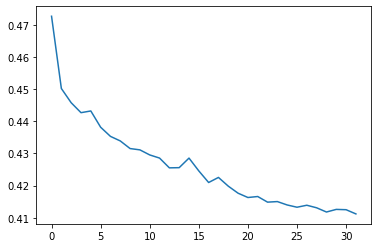

In [ ]:
# plot losses
plt.plot(CLF_model.history['loss'])

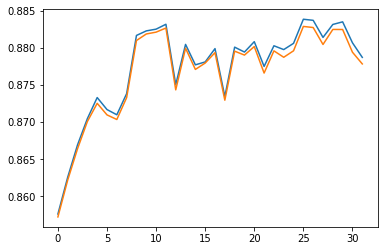

In [ ]:
# plot auc
plt.plot(CLF_model.history['train_auc'])
plt.plot(CLF_model.history['test_auc'])

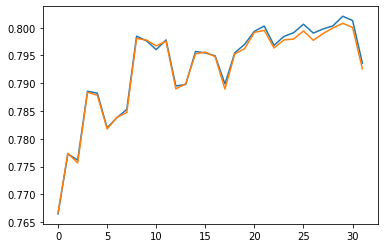

In [ ]:
# plot accuracy
plt.plot(CLF_model.history['train_accuracy'])
plt.plot(CLF_model.history['test_accuracy'])

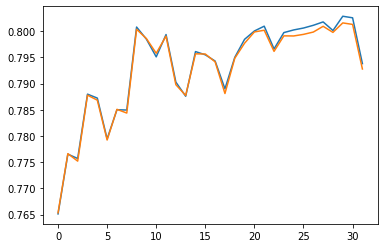

In [ ]:
# plot accuracy
plt.plot(CLF_model.history['train_balanced_accuracy'])
plt.plot(CLF_model.history['test_balanced_accuracy'])

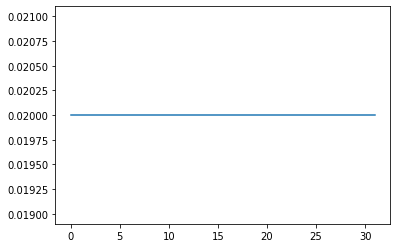

In [ ]:
# plot learning rates
plt.plot(CLF_model.history['lr'])

In [ ]:
preds = CLF_model.predict_proba(X_test.values)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test.values.reshape(-1,1))

In [ ]:
print(f"BEST VALID SCORE FOR : {CLF_model.best_cost}")
print(f"FINAL TEST SCORE FOR : {test_auc}")

BEST VALID SCORE FOR : 0.4298531275304917
FINAL TEST SCORE FOR : 0.8826714880667572


In [ ]:
# print('Training accuracy {:.4f}'.format(CLF_model.score(X_train.values,y_train.values.reshape(-1,1))))
# print('Testing accuracy {:.4f}'.format(CLF_model.score(X_test.values,y_test.values.reshape(-1,1))))
print(classification_report(y_test.values.reshape(-1,1),CLF_model.predict(X_test.values)))
# print(plot_confusion_matrix(CLF_model,X_test.values,y_test.values.reshape(-1,1),cmap='Blues_r'))
pd.DataFrame({'Value':CLF_model.feature_importances_,'Feature':X.columns}).sort_values(by="Value",ascending=False).head(15)

              precision    recall  f1-score   support

           0       0.83      0.77      0.80    145301
           1       0.76      0.83      0.80    132548

    accuracy                           0.80    277849
   macro avg       0.80      0.80      0.80    277849
weighted avg       0.80      0.80      0.80    277849



,Value,Feature
74,0.281786,p_resale
0,0.139503,nft_sales_count
75,0.078592,pca_1
38,0.066405,Price_USD_median_7d
81,0.058603,deg_centrality_seller
28,0.049359,WAX_price_14d_rolling_avg
26,0.047958,MANA_price_90d_rolling_avg
77,0.031791,pca_3
73,0.025585,Price_Crypto_collection_cum_max
18,0.021011,ETH_price_14d_rolling_avg


In [ ]:
print(CLF_model.best_cost)

0.4298531275304917


In [ ]:
y_pred = CLF_model.predict(X_test.values)

In [ ]:
def get_model_results2(model, X_train, y_train, X_test, y_test, y_pred):
    # train_acc_score = model.score(X_train, y_train)
    # test_acc_score = model.score(X_test, y_test)
    bal_acc_score = balanced_accuracy_score(y_test, y_pred)
    temp_f1_score = f1_score(y_test, y_pred)
    temp_precision_score = precision_score(y_test, y_pred)
    temp_recall_score = recall_score(y_test, y_pred)
    temp_roc_auc_score = roc_auc_score(y_test, y_pred)
    return bal_acc_score, temp_f1_score, temp_precision_score, temp_recall_score, temp_roc_auc_score

In [ ]:
bal_acc_score, clf_f1_score, clf_precision_score, clf_recall_score, clf_roc_auc_score = get_model_results2(CLF_model, X_train, y_train, X_test, y_test, y_pred)
print("balanced_acc_score: ", bal_acc_score)
print("f1_score: ", clf_f1_score)
print("precision_score: ", clf_precision_score)
print("recall_score: ", clf_recall_score)
print("roc_auc_score: ", clf_roc_auc_score)

balanced_acc_score:  0.7990412211607139
f1_score:  0.7966552064466449
precision_score:  0.7648218463012196
recall_score:  0.8312535836074478
roc_auc_score:  0.799041221160714


In [ ]:
CLF_cr = classification_report(y_test,y_pred)
print(CLF_cr)

              precision    recall  f1-score   support

           0       0.83      0.77      0.80    145301
           1       0.76      0.83      0.80    132548

    accuracy                           0.80    277849
   macro avg       0.80      0.80      0.80    277849
weighted avg       0.80      0.80      0.80    277849



In [ ]:
pd.DataFrame({'Value':np.squeeze(CLF_model.feature_importances_),'Feature':X.columns}).sort_values(by="Value",ascending=False).head(15)

,Value,Feature
74,0.281786,p_resale
0,0.139503,nft_sales_count
75,0.078592,pca_1
38,0.066405,Price_USD_median_7d
81,0.058603,deg_centrality_seller
28,0.049359,WAX_price_14d_rolling_avg
26,0.047958,MANA_price_90d_rolling_avg
77,0.031791,pca_3
73,0.025585,Price_Crypto_collection_cum_max
18,0.021011,ETH_price_14d_rolling_avg


In [ ]:
write_model_results_3(CLF_model, 'secondary-tabnet-fillcustom-nobal-noscale')
model_results_dict.keys()

dict_keys(['secondary-tabnet-fill0-nobal-noscale', 'secondary-tabnet-fill0-nobal-minmaxscale', 'secondary-tabnet-fillcustom-nobal-noscale'])

In [ ]:
df_model_results = pd.DataFrame(model_results_dict).transpose().reset_index().rename(columns={'index':'unique_model_name'})
print(len(df_model_results))
df_model_results.head()

3


,unique_model_name,model_scope,model_type,balance_method,scale_method,balance_acc_score,f1_score,precision_score,recall_score,roc_auc_score,classification_report,features,coef_values,date_recorded
0,secondary-tabnet-fill0-nobal-noscale,NFT secondary sales,"TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamm...",None,None,0.802719,0.796347,0.781445,0.811828,0.802719,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[0.212438048620167, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",2022-04-08-14:02:12
1,secondary-tabnet-fill0-nobal-minmaxscale,NFT secondary sales,"TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamm...",None,MinMaxScaler,0.781621,0.763385,0.797858,0.731768,0.781621,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[0.16480028167624844, 0.002095364407039438, 0....",2022-04-08-14:39:00
2,secondary-tabnet-fillcustom-nobal-noscale,NFT secondary sales,"TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamm...",None,None,0.799041,0.796655,0.764822,0.831254,0.799041,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[0.13950349445035315, 0.010005813196791297, 0....",2022-04-08-15:39:58


In [ ]:
df_model_results.to_pickle('/content/drive/My Drive/df_model_results_tabnet.pkl')

TabNet - FillNA=Custom, Unbalanced, Scaled

In [ ]:
# model characteristics to record with results
model_scope = 'NFT secondary sales'
# model_type = use CLF_model
fillna_method = 'Fill NaNs with custom method'
balance_method = 'None'
scale_method = 'MinMaxScaler'

In [ ]:
X, y, indices = get_x_and_y(df_collection_nft_second, 1)
print(len(X), len(y), len(indices))

1389242 1389242 1389242


In [ ]:
X_train, X_test, y_train, y_test, indices_train, indices_test = get_scaled_train_test_splits(X, y, indices)
print(len(X_train), len(X_test), len(y_train), len(y_test), len(indices_train), len(indices_test))

1111393 277849 1111393 277849 1111393 277849


In [ ]:
tabnet_params = {"optimizer_fn":torch.optim.Adam,
                 "optimizer_params":dict(lr=2e-2),
                 "scheduler_params":{"step_size":50, # how to use learning rate scheduler
                                 "gamma":0.9},
                 "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                 "mask_type":'entmax' # "sparsemax"
                }

CLF_model = TabNetClassifier(**tabnet_params
                      )

Device used : cuda


In [ ]:
max_epochs = 50 if not os.getenv("CI", False) else 2

In [ ]:
# This illustrates the warm_start=False behaviour
save_history = []
for _ in range(2):
    CLF_model.fit(
        X_train=X_train, y_train=y_train.values,
        eval_set=[(X_train, y_train.values), (X_test, y_test.values)],
        eval_name=['train', 'test'],
        eval_metric=['accuracy', 'balanced_accuracy', 'auc', 'logloss'],
        max_epochs=max_epochs , patience=20,
        batch_size=1024, virtual_batch_size=128,
        num_workers=0,
        weights=1,
        drop_last=False,
        #augmentations=aug, #aug, None
    )
    save_history.append(CLF_model.history["test_accuracy", "test_bal_accuracy", "test_auc", "test_logloss"])

assert(np.all(np.array(save_history[0]==np.array(save_history[1]))))

epoch 0  | loss: 0.46991 | train_accuracy: 0.78731 | train_balanced_accuracy: 0.78843 | train_auc: 0.8693  | train_logloss: 0.45099 | test_accuracy: 0.78737 | test_balanced_accuracy: 0.78841 | test_auc: 0.86922 | test_logloss: 0.45127 |  0:01:04s
epoch 1  | loss: 0.44847 | train_accuracy: 0.7913  | train_balanced_accuracy: 0.79442 | train_auc: 0.87544 | train_logloss: 0.4429  | test_accuracy: 0.79008 | test_balanced_accuracy: 0.79315 | test_auc: 0.87447 | test_logloss: 0.44462 |  0:02:09s
epoch 2  | loss: 0.44157 | train_accuracy: 0.79425 | train_balanced_accuracy: 0.7954  | train_auc: 0.87694 | train_logloss: 0.43688 | test_accuracy: 0.79261 | test_balanced_accuracy: 0.79362 | test_auc: 0.8761  | test_logloss: 0.4383  |  0:03:13s
epoch 3  | loss: 0.43883 | train_accuracy: 0.78162 | train_balanced_accuracy: 0.78678 | train_auc: 0.87664 | train_logloss: 0.44476 | test_accuracy: 0.7812  | test_balanced_accuracy: 0.78633 | test_auc: 0.87552 | test_logloss: 0.44624 |  0:04:18s
epoch 4  | l

KeyError: ignored

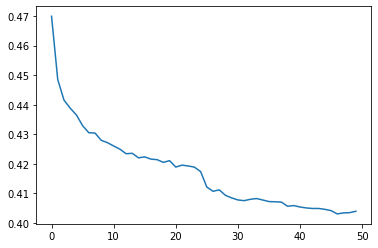

In [ ]:
# plot losses
plt.plot(CLF_model.history['loss'])

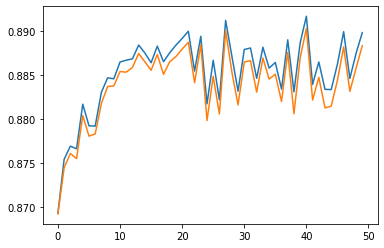

In [ ]:
# plot auc
plt.plot(CLF_model.history['train_auc'])
plt.plot(CLF_model.history['test_auc'])

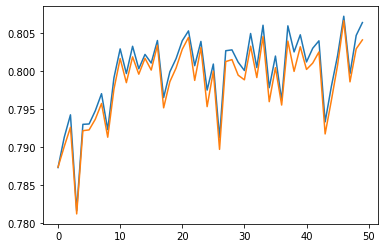

In [ ]:
# plot accuracy
plt.plot(CLF_model.history['train_accuracy'])
plt.plot(CLF_model.history['test_accuracy'])

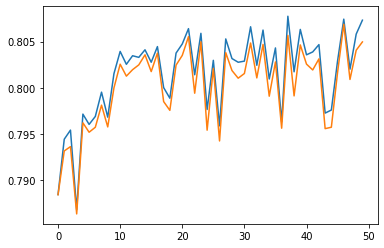

In [ ]:
# plot accuracy
plt.plot(CLF_model.history['train_balanced_accuracy'])
plt.plot(CLF_model.history['test_balanced_accuracy'])

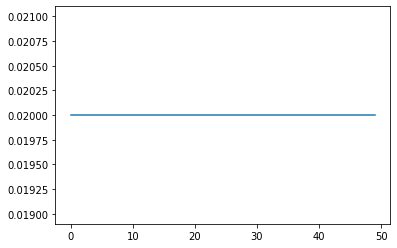

In [ ]:
# plot learning rates
plt.plot(CLF_model.history['lr'])

In [ ]:
preds = CLF_model.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test.values.reshape(-1,1))

In [ ]:
print(f"BEST VALID SCORE FOR : {CLF_model.best_cost}")
print(f"FINAL TEST SCORE FOR : {test_auc}")

BEST VALID SCORE FOR : 0.4122430717602836
FINAL TEST SCORE FOR : 0.8903290726059605


In [ ]:
# print('Training accuracy {:.4f}'.format(CLF_model.score(X_train.values,y_train.values.reshape(-1,1))))
# print('Testing accuracy {:.4f}'.format(CLF_model.score(X_test.values,y_test.values.reshape(-1,1))))
print(classification_report(y_test.values.reshape(-1,1),CLF_model.predict(X_test)))
# print(plot_confusion_matrix(CLF_model,X_test,y_test.values.reshape(-1,1),cmap='Blues_r'))
pd.DataFrame({'Value':CLF_model.feature_importances_,'Feature':X.columns}).sort_values(by="Value",ascending=False).head(15)

              precision    recall  f1-score   support

           0       0.85      0.75      0.80    145301
           1       0.76      0.85      0.80    132548

    accuracy                           0.80    277849
   macro avg       0.80      0.80      0.80    277849
weighted avg       0.81      0.80      0.80    277849



,Value,Feature
82,0.137884,pgrank_seller
12,0.129146,BTC_price_7d_rolling_avg
0,0.096782,nft_sales_count
83,0.093339,trans_count_buyer
1,0.072434,First_item_Unique_id_collection
86,0.061875,Category_Art
84,0.059148,deg_centrality_buyer
25,0.056593,MANA_price_60d_rolling_avg
18,0.048382,ETH_price_14d_rolling_avg
81,0.038115,deg_centrality_seller


In [ ]:
print(CLF_model.best_cost)

0.4122430717602836


In [ ]:
y_pred = CLF_model.predict(X_test)

In [ ]:
bal_acc_score, clf_f1_score, clf_precision_score, clf_recall_score, clf_roc_auc_score = get_model_results2(CLF_model, X_train, y_train, X_test, y_test, y_pred)
print("balanced_acc_score: ", bal_acc_score)
print("f1_score: ", clf_f1_score)
print("precision_score: ", clf_precision_score)
print("recall_score: ", clf_recall_score)
print("roc_auc_score: ", clf_roc_auc_score)

balanced_acc_score:  0.8025523727885995
f1_score:  0.8029312664874864
precision_score:  0.7583514972670266
recall_score:  0.8530796390741467
roc_auc_score:  0.8025523727885995


In [ ]:
CLF_cr = classification_report(y_test,y_pred)
print(CLF_cr)

              precision    recall  f1-score   support

           0       0.85      0.75      0.80    145301
           1       0.76      0.85      0.80    132548

    accuracy                           0.80    277849
   macro avg       0.80      0.80      0.80    277849
weighted avg       0.81      0.80      0.80    277849



In [ ]:
pd.DataFrame({'Value':np.squeeze(CLF_model.feature_importances_),'Feature':X.columns}).sort_values(by="Value",ascending=False).head(15)

,Value,Feature
82,0.137884,pgrank_seller
12,0.129146,BTC_price_7d_rolling_avg
0,0.096782,nft_sales_count
83,0.093339,trans_count_buyer
1,0.072434,First_item_Unique_id_collection
86,0.061875,Category_Art
84,0.059148,deg_centrality_buyer
25,0.056593,MANA_price_60d_rolling_avg
18,0.048382,ETH_price_14d_rolling_avg
81,0.038115,deg_centrality_seller


In [ ]:
write_model_results_3(CLF_model, 'secondary-tabnet-fillcustom-nobal-minmaxscale')
model_results_dict.keys()

dict_keys(['secondary-tabnet-fill0-nobal-noscale', 'secondary-tabnet-fill0-nobal-minmaxscale', 'secondary-tabnet-fillcustom-nobal-noscale', 'secondary-tabnet-fillcustom-nobal-minmaxscale'])

In [ ]:
df_model_results = pd.DataFrame(model_results_dict).transpose().reset_index().rename(columns={'index':'unique_model_name'})
print(len(df_model_results))
df_model_results.head()

4


,unique_model_name,model_scope,model_type,balance_method,scale_method,balance_acc_score,f1_score,precision_score,recall_score,roc_auc_score,classification_report,features,coef_values,date_recorded
0,secondary-tabnet-fill0-nobal-noscale,NFT secondary sales,"TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamm...",None,None,0.802719,0.796347,0.781445,0.811828,0.802719,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[0.212438048620167, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",2022-04-08-14:02:12
1,secondary-tabnet-fill0-nobal-minmaxscale,NFT secondary sales,"TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamm...",None,MinMaxScaler,0.781621,0.763385,0.797858,0.731768,0.781621,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[0.16480028167624844, 0.002095364407039438, 0....",2022-04-08-14:39:00
2,secondary-tabnet-fillcustom-nobal-noscale,NFT secondary sales,"TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamm...",None,None,0.799041,0.796655,0.764822,0.831254,0.799041,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[0.13950349445035315, 0.010005813196791297, 0....",2022-04-08-15:39:58
3,secondary-tabnet-fillcustom-nobal-minmaxscale,NFT secondary sales,"TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamm...",None,MinMaxScaler,0.802552,0.802931,0.758351,0.85308,0.802552,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[0.09678208083604772, 0.07243406087793339, 3.3...",2022-04-08-17:44:21


In [ ]:
df_model_results.to_pickle('/content/drive/My Drive/df_model_results_tabnet.pkl')

In [ ]:
model_results_dict.keys()

dict_keys(['secondary-tabnet-fill0-nobal-noscale', 'secondary-tabnet-fill0-nobal-minmaxscale', 'secondary-tabnet-fillcustom-nobal-noscale', 'secondary-tabnet-fillcustom-nobal-minmaxscale'])

Predict whether sales of NFTs that were sold between 2-49 times would increase or decrease

In [15]:
df_collection_nft_second_2_50 = df_all_values[(df_all_values['nft_sales_count'] > 1) & (df_all_values['nft_sales_count'] < 50)]
print(len(df_collection_nft_second_2_50))
df_collection_nft_second_2_50.head()

2293360


,Smart_contract,ID_token,Transaction_hash,Seller_address,Seller_username,Buyer_address,Buyer_username,Image_url_1,Image_url_2,Image_url_3,...,pca_2,pca_3,pca_4,pca_5,trans_count_seller,deg_centrality_seller,pgrank_seller,trans_count_buyer,deg_centrality_buyer,pgrank_buyer
6,0x8ae8d2ae74a96595bcdab803b563f594009e3db2,18,0xc9cbdfeaae0b56646844eba98d2d83da098707b82a19...,0xd5f4bbd4d1f9ecf3bccb12ac8a2c8bdc5b45b482,Crypto_Wizard_89,0x61592a6f682bbabfd743aa7596ee269e7448212c,AceKennedy,https://lh3.googleusercontent.com/sqP3FLVmlLr6...,http://www.aicryptoart.org/artpieces/18_Specia...,https://lh3.googleusercontent.com/sqP3FLVmlLr6...,...,2.565265,25.302385,-15.823856,-1.457436,1,0.000021,0.000001,1,0.002481,2.263459e-04
26,0x5f4becdcfcbeaf8274b6905b101aaf44ac10012c,23,0xa52e91d4f8f6c395c6e701f657a0e50b2bd5245f3c5c...,0xdc546f477f273bcf327297bf4adcb671b5f20be1,BlackBoxDotArt,0x425a2ca37c24b96a3935e78f54c31d8aac78208f,jfcBishop,https://lh3.googleusercontent.com/NW1g3yh7wWAj...,https://ipfs.io/ipfs/QmVGvA4ekoduGrfeJGj6X3nhn...,https://lh3.googleusercontent.com/NW1g3yh7wWAj...,...,NaN,NaN,NaN,NaN,1,0.000430,0.000020,1,0.000435,4.930488e-05
27,0x5f4becdcfcbeaf8274b6905b101aaf44ac10012c,23,0x3f5fb3c302839bff08c5b9efac7011d92c2a26a7338a...,0x425a2ca37c24b96a3935e78f54c31d8aac78208f,jfcBishop,0x2b706e5955ade3033613b33a207f0a4ecf182f1d,lokh,https://lh3.googleusercontent.com/NW1g3yh7wWAj...,https://ipfs.io/ipfs/QmVGvA4ekoduGrfeJGj6X3nhn...,https://lh3.googleusercontent.com/NW1g3yh7wWAj...,...,NaN,NaN,NaN,NaN,1,0.000435,0.000016,1,0.000030,9.367911e-07
52,0xef547d017f64863a1a741864d900956081744238,67,0x6266ab37c74a31d75a9506c9fb927e2fb0dba1ffcc4b...,0x73b4437a4b3e43de673836107437e4f092a363e0,Bitcoin,0xb88555545e36ad0eee39e401e5f47cfa7d580df1,cmodgli,https://lh3.googleusercontent.com/AHu4hho7-a6H...,NaN,https://lh3.googleusercontent.com/AHu4hho7-a6H...,...,3.365610,14.981804,-14.954402,0.377541,2,0.000295,0.000007,2,0.000032,1.760260e-06
136,0x495f947276749ce646f68ac8c248420045cb7b5e,8608896838368138576952528182966876787734253624...,0xecb2520b6d9a2562ca839d94f83ad0fff376513e6f1f...,0xbe54a11e59d1ee3c04ca5f6c7773ebc759cd1afd,squidGAN,0x12c39a34c51302072ae7f08efc3b8276f1b67a06,UltraPotato2,https://lh3.googleusercontent.com/GTdqVu8wAEr4...,NaN,https://lh3.googleusercontent.com/GTdqVu8wAEr4...,...,-2.301886,22.523252,-14.456810,5.132076,1,0.000021,0.000001,1,0.000004,7.899614e-07


TabNet - FillNA=0, Unbalanced, Unscaled

In [ ]:
# model characteristics to record with results
model_scope = 'NFT sales 2-49'
# model_type = use CLF_model
fillna_method = 'Fill NaNs with zeroes'
balance_method = 'None'
scale_method = 'None'

In [ ]:
X, y, indices = get_x_and_y(df_collection_nft_second_2_50, 0)
print(len(X), len(y), len(indices))

2293360 2293360 2293360


In [ ]:
X_train, X_test, y_train, y_test, indices_train, indices_test = get_train_test_splits(X, y, indices)
print(len(X_train), len(X_test), len(y_train), len(y_test), len(indices_train), len(indices_test))

1834688 458672 1834688 458672 1834688 458672


In [ ]:
tabnet_params = {"optimizer_fn":torch.optim.Adam,
                 "optimizer_params":dict(lr=2e-2),
                 "scheduler_params":{"step_size":50, # how to use learning rate scheduler
                                 "gamma":0.9},
                 "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                 "mask_type":'entmax' # "sparsemax"
                }

CLF_model = TabNetClassifier(**tabnet_params
                      )

Device used : cuda


In [ ]:
max_epochs = 50 if not os.getenv("CI", False) else 2

In [ ]:
# This illustrates the warm_start=False behaviour
save_history = []
for _ in range(2):
    CLF_model.fit(
        X_train=X_train.values, y_train=y_train.values,
        eval_set=[(X_train.values, y_train.values), (X_test.values, y_test.values)],
        eval_name=['train', 'test'],
        eval_metric=['accuracy', 'balanced_accuracy', 'auc', 'logloss'],
        max_epochs=max_epochs , patience=20,
        batch_size=1024, virtual_batch_size=128,
        num_workers=0,
        weights=1,
        drop_last=False,
        #augmentations=aug, #aug, None
    )
    save_history.append(CLF_model.history["test_accuracy", "test_bal_accuracy", "test_auc", "test_logloss"])

assert(np.all(np.array(save_history[0]==np.array(save_history[1]))))

epoch 0  | loss: 0.28291 | train_accuracy: 0.85813 | train_balanced_accuracy: 0.88662 | train_auc: 0.94866 | train_logloss: 0.27411 | test_accuracy: 0.85779 | test_balanced_accuracy: 0.88627 | test_auc: 0.94816 | test_logloss: 0.2747  |  0:02:55s
epoch 1  | loss: 0.26192 | train_accuracy: 0.85674 | train_balanced_accuracy: 0.8872  | train_auc: 0.9496  | train_logloss: 0.27965 | test_accuracy: 0.85647 | test_balanced_accuracy: 0.8869  | test_auc: 0.94935 | test_logloss: 0.27994 |  0:05:52s
epoch 2  | loss: 0.25825 | train_accuracy: 0.85973 | train_balanced_accuracy: 0.88828 | train_auc: 0.9517  | train_logloss: 0.28008 | test_accuracy: 0.85956 | test_balanced_accuracy: 0.88798 | test_auc: 0.95135 | test_logloss: 0.28043 |  0:08:50s
epoch 3  | loss: 0.25566 | train_accuracy: 0.85969 | train_balanced_accuracy: 0.88985 | train_auc: 0.95261 | train_logloss: 0.28002 | test_accuracy: 0.85946 | test_balanced_accuracy: 0.88937 | test_auc: 0.95206 | test_logloss: 0.28049 |  0:11:48s
epoch 4  | l

KeyError: ignored

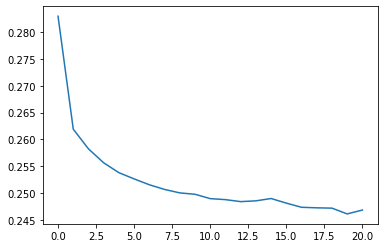

In [ ]:
# plot losses
plt.plot(CLF_model.history['loss'])

In [ ]:
# # plot auc
# plt.plot(CLF_model.history['train_auc'])
# plt.plot(CLF_model.history['test_auc'])

In [ ]:
# # plot accuracy
# plt.plot(CLF_model.history['train_accuracy'])
# plt.plot(CLF_model.history['test_accuracy'])

In [ ]:
# # plot accuracy
# plt.plot(CLF_model.history['train_balanced_accuracy'])
# plt.plot(CLF_model.history['test_balanced_accuracy'])

In [ ]:
# # plot learning rates
# plt.plot(CLF_model.history['lr'])

In [ ]:
preds = CLF_model.predict_proba(X_test.values)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test.values.reshape(-1,1))

In [ ]:
print(f"BEST VALID SCORE FOR : {CLF_model.best_cost}")
print(f"FINAL TEST SCORE FOR : {test_auc}")

BEST VALID SCORE FOR : 0.2747047475076163
FINAL TEST SCORE FOR : 0.9481640406080475


In [ ]:
# print('Training accuracy {:.4f}'.format(CLF_model.score(X_train.values,y_train.values.reshape(-1,1))))
# print('Testing accuracy {:.4f}'.format(CLF_model.score(X_test.values,y_test.values.reshape(-1,1))))
print(classification_report(y_test.values.reshape(-1,1),CLF_model.predict(X_test.values)))
# print(plot_confusion_matrix(CLF_model,X_test.values,y_test.values.reshape(-1,1),cmap='Blues_r'))
pd.DataFrame({'Value':CLF_model.feature_importances_,'Feature':X.columns}).sort_values(by="Value",ascending=False).head(15)

              precision    recall  f1-score   support

           0       0.98      0.82      0.89    329623
           1       0.68      0.95      0.79    129049

    accuracy                           0.86    458672
   macro avg       0.83      0.89      0.84    458672
weighted avg       0.89      0.86      0.86    458672



,Value,Feature
1,0.378593,First_item_Unique_id_collection
25,0.116146,MANA_price_60d_rolling_avg
14,0.064848,BTC_price_30d_rolling_avg
15,0.058068,BTC_price_60d_rolling_avg
46,0.045212,Price_USD_median_90d
4,0.036839,ETH_price
88,0.033618,Category_Games
16,0.032376,BTC_price_90d_rolling_avg
2,0.026134,GoogleTrends
81,0.025131,deg_centrality_seller


In [ ]:
print(CLF_model.best_cost)

0.2747047475076163


In [ ]:
y_pred = CLF_model.predict(X_test.values)

In [ ]:
def get_model_results2(model, X_train, y_train, X_test, y_test, y_pred):
    # train_acc_score = model.score(X_train, y_train)
    # test_acc_score = model.score(X_test, y_test)
    bal_acc_score = balanced_accuracy_score(y_test, y_pred)
    temp_f1_score = f1_score(y_test, y_pred)
    temp_precision_score = precision_score(y_test, y_pred)
    temp_recall_score = recall_score(y_test, y_pred)
    temp_roc_auc_score = roc_auc_score(y_test, y_pred)
    return bal_acc_score, temp_f1_score, temp_precision_score, temp_recall_score, temp_roc_auc_score

In [ ]:
bal_acc_score, clf_f1_score, clf_precision_score, clf_recall_score, clf_roc_auc_score = get_model_results2(CLF_model, X_train, y_train, X_test, y_test, y_pred)
print("balanced_acc_score: ", bal_acc_score)
print("f1_score: ", clf_f1_score)
print("precision_score: ", clf_precision_score)
print("recall_score: ", clf_recall_score)
print("roc_auc_score: ", clf_roc_auc_score)

balanced_acc_score:  0.8862720715612655
f1_score:  0.7901178953871499
precision_score:  0.6755880815473079
recall_score:  0.9514060550643554
roc_auc_score:  0.8862720715612654


In [ ]:
CLF_cr = classification_report(y_test,y_pred)
print(CLF_cr)

              precision    recall  f1-score   support

           0       0.98      0.82      0.89    329623
           1       0.68      0.95      0.79    129049

    accuracy                           0.86    458672
   macro avg       0.83      0.89      0.84    458672
weighted avg       0.89      0.86      0.86    458672



In [ ]:
pd.DataFrame({'Value':np.squeeze(CLF_model.feature_importances_),'Feature':X.columns}).sort_values(by="Value",ascending=False).head(15)

,Value,Feature
1,0.378593,First_item_Unique_id_collection
25,0.116146,MANA_price_60d_rolling_avg
14,0.064848,BTC_price_30d_rolling_avg
15,0.058068,BTC_price_60d_rolling_avg
46,0.045212,Price_USD_median_90d
4,0.036839,ETH_price
88,0.033618,Category_Games
16,0.032376,BTC_price_90d_rolling_avg
2,0.026134,GoogleTrends
81,0.025131,deg_centrality_seller


In [ ]:
write_model_results_3(CLF_model, 'secondary2-49-tabnet-fill0-nobal-noscale')
model_results_dict.keys()

dict_keys(['secondary-tabnet-fill0-nobal-noscale', 'secondary-tabnet-fill0-nobal-minmaxscale', 'secondary-tabnet-fillcustom-nobal-noscale', 'secondary-tabnet-fillcustom-nobal-minmaxscale', 'secondary2-49-tabnet-fill0-nobal-noscale'])

In [ ]:
df_model_results = pd.DataFrame(model_results_dict).transpose().reset_index().rename(columns={'index':'unique_model_name'})
print(len(df_model_results))
df_model_results.head()

5


,unique_model_name,model_scope,model_type,balance_method,scale_method,balance_acc_score,f1_score,precision_score,recall_score,roc_auc_score,classification_report,features,coef_values,date_recorded
0,secondary-tabnet-fill0-nobal-noscale,NFT secondary sales,"TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamm...",None,None,0.802719,0.796347,0.781445,0.811828,0.802719,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[0.212438048620167, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",2022-04-08-14:02:12
1,secondary-tabnet-fill0-nobal-minmaxscale,NFT secondary sales,"TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamm...",None,MinMaxScaler,0.781621,0.763385,0.797858,0.731768,0.781621,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[0.16480028167624844, 0.002095364407039438, 0....",2022-04-08-14:39:00
2,secondary-tabnet-fillcustom-nobal-noscale,NFT secondary sales,"TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamm...",None,None,0.799041,0.796655,0.764822,0.831254,0.799041,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[0.13950349445035315, 0.010005813196791297, 0....",2022-04-08-15:39:58
3,secondary-tabnet-fillcustom-nobal-minmaxscale,NFT secondary sales,"TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamm...",None,MinMaxScaler,0.802552,0.802931,0.758351,0.85308,0.802552,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[0.09678208083604772, 0.07243406087793339, 3.3...",2022-04-08-17:44:21
4,secondary2-49-tabnet-fill0-nobal-noscale,NFT sales 2-49,"TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamm...",None,None,0.886272,0.790118,0.675588,0.951406,0.886272,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[6.883974770867169e-06, 0.3785931395110315, 0....",2022-04-08-22:35:07


In [ ]:
df_model_results.to_pickle('/content/drive/My Drive/df_model_results_tabnet.pkl')

TabNet - FillNA=0, Unbalanced, Scaled

In [ ]:
# model characteristics to record with results
model_scope = 'NFT sales 2-49'
# model_type = use CLF_model
fillna_method = 'Fill NaNs with zeroes'
balance_method = 'None'
scale_method = 'MinMaxScaler'

In [ ]:
X, y, indices = get_x_and_y(df_collection_nft_second_2_50, 0)
print(len(X), len(y), len(indices))

2293360 2293360 2293360


In [ ]:
X_train, X_test, y_train, y_test, indices_train, indices_test = get_scaled_train_test_splits(X, y, indices)
print(len(X_train), len(X_test), len(y_train), len(y_test), len(indices_train), len(indices_test))

1834688 458672 1834688 458672 1834688 458672


In [ ]:
tabnet_params = {"optimizer_fn":torch.optim.Adam,
                 "optimizer_params":dict(lr=2e-2),
                 "scheduler_params":{"step_size":50, # how to use learning rate scheduler
                                 "gamma":0.9},
                 "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                 "mask_type":'entmax' # "sparsemax"
                }

CLF_model = TabNetClassifier(**tabnet_params
                      )

Device used : cuda


In [ ]:
max_epochs = 50 if not os.getenv("CI", False) else 2

In [ ]:
# This illustrates the warm_start=False behaviour
save_history = []
for _ in range(2):
    CLF_model.fit(
        X_train=X_train, y_train=y_train.values,
        eval_set=[(X_train, y_train.values), (X_test, y_test.values)],
        eval_name=['train', 'test'],
        eval_metric=['accuracy', 'balanced_accuracy', 'auc', 'logloss'],
        max_epochs=max_epochs , patience=20,
        batch_size=1024, virtual_batch_size=128,
        num_workers=0,
        weights=1,
        drop_last=False,
        #augmentations=aug, #aug, None
    )
    save_history.append(CLF_model.history["test_accuracy", "test_bal_accuracy", "test_auc", "test_logloss"])

assert(np.all(np.array(save_history[0]==np.array(save_history[1]))))

epoch 0  | loss: 0.28127 | train_accuracy: 0.86951 | train_balanced_accuracy: 0.88157 | train_auc: 0.94581 | train_logloss: 0.26481 | test_accuracy: 0.86912 | test_balanced_accuracy: 0.88278 | test_auc: 0.94496 | test_logloss: 0.2672  |  0:01:51s
epoch 1  | loss: 0.26194 | train_accuracy: 0.85617 | train_balanced_accuracy: 0.88643 | train_auc: 0.9476  | train_logloss: 0.29256 | test_accuracy: 0.85545 | test_balanced_accuracy: 0.88639 | test_auc: 0.94632 | test_logloss: 0.29705 |  0:03:44s
epoch 2  | loss: 0.25858 | train_accuracy: 0.86924 | train_balanced_accuracy: 0.88651 | train_auc: 0.94842 | train_logloss: 0.28362 | test_accuracy: 0.869   | test_balanced_accuracy: 0.88695 | test_auc: 0.94829 | test_logloss: 0.28506 |  0:05:36s
epoch 3  | loss: 0.25782 | train_accuracy: 0.86815 | train_balanced_accuracy: 0.88745 | train_auc: 0.95067 | train_logloss: 0.28412 | test_accuracy: 0.86709 | test_balanced_accuracy: 0.88797 | test_auc: 0.95045 | test_logloss: 0.28644 |  0:07:28s
epoch 4  | l

KeyError: ignored

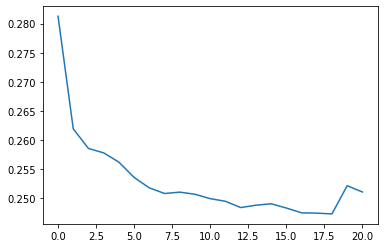

In [ ]:
# plot losses
plt.plot(CLF_model.history['loss'])

In [ ]:
# # plot auc
# plt.plot(CLF_model.history['train_auc'])
# plt.plot(CLF_model.history['test_auc'])

In [ ]:
# # plot accuracy
# plt.plot(CLF_model.history['train_accuracy'])
# plt.plot(CLF_model.history['test_accuracy'])

In [ ]:
# # plot accuracy
# plt.plot(CLF_model.history['train_balanced_accuracy'])
# plt.plot(CLF_model.history['test_balanced_accuracy'])

In [ ]:
# # plot learning rates
# plt.plot(CLF_model.history['lr'])

In [ ]:
preds = CLF_model.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test.values.reshape(-1,1))

In [ ]:
print(f"BEST VALID SCORE FOR : {CLF_model.best_cost}")
print(f"FINAL TEST SCORE FOR : {test_auc}")

BEST VALID SCORE FOR : 0.2672046284585124
FINAL TEST SCORE FOR : 0.9449623923169381


In [ ]:
# print('Training accuracy {:.4f}'.format(CLF_model.score(X_train.values,y_train.values.reshape(-1,1))))
# print('Testing accuracy {:.4f}'.format(CLF_model.score(X_test.values,y_test.values.reshape(-1,1))))
print(classification_report(y_test.values.reshape(-1,1),CLF_model.predict(X_test)))
# print(plot_confusion_matrix(CLF_model,X_test,y_test.values.reshape(-1,1),cmap='Blues_r'))
pd.DataFrame({'Value':CLF_model.feature_importances_,'Feature':X.columns}).sort_values(by="Value",ascending=False).head(15)

              precision    recall  f1-score   support

           0       0.96      0.85      0.90    329623
           1       0.71      0.91      0.80    129049

    accuracy                           0.87    458672
   macro avg       0.83      0.88      0.85    458672
weighted avg       0.89      0.87      0.87    458672



,Value,Feature
58,0.368405,Price_Crypto_median_30d
14,0.252014,BTC_price_30d_rolling_avg
82,0.059530,pgrank_seller
81,0.032741,deg_centrality_seller
21,0.028626,ETH_price_90d_rolling_avg
73,0.028287,Price_Crypto_collection_cum_max
88,0.022708,Category_Games
15,0.020266,BTC_price_60d_rolling_avg
25,0.018735,MANA_price_60d_rolling_avg
86,0.018384,Category_Art


In [ ]:
print(CLF_model.best_cost)

0.2672046284585124


In [ ]:
y_pred = CLF_model.predict(X_test)

In [ ]:
bal_acc_score, clf_f1_score, clf_precision_score, clf_recall_score, clf_roc_auc_score = get_model_results2(CLF_model, X_train, y_train, X_test, y_test, y_pred)
print("balanced_acc_score: ", bal_acc_score)
print("f1_score: ", clf_f1_score)
print("precision_score: ", clf_precision_score)
print("recall_score: ", clf_recall_score)
print("roc_auc_score: ", clf_roc_auc_score)

balanced_acc_score:  0.8827805141869036
f1_score:  0.7971534097244984
precision_score:  0.7067903453896119
recall_score:  0.9140094072794055
roc_auc_score:  0.8827805141869035


In [ ]:
CLF_cr = classification_report(y_test,y_pred)
print(CLF_cr)

              precision    recall  f1-score   support

           0       0.96      0.85      0.90    329623
           1       0.71      0.91      0.80    129049

    accuracy                           0.87    458672
   macro avg       0.83      0.88      0.85    458672
weighted avg       0.89      0.87      0.87    458672



In [ ]:
pd.DataFrame({'Value':np.squeeze(CLF_model.feature_importances_),'Feature':X.columns}).sort_values(by="Value",ascending=False).head(15)

,Value,Feature
58,0.368405,Price_Crypto_median_30d
14,0.252014,BTC_price_30d_rolling_avg
82,0.059530,pgrank_seller
81,0.032741,deg_centrality_seller
21,0.028626,ETH_price_90d_rolling_avg
73,0.028287,Price_Crypto_collection_cum_max
88,0.022708,Category_Games
15,0.020266,BTC_price_60d_rolling_avg
25,0.018735,MANA_price_60d_rolling_avg
86,0.018384,Category_Art


In [ ]:
write_model_results_3(CLF_model, 'secondary2-49-tabnet-fill0-nobal-minmaxscale')
model_results_dict.keys()

dict_keys(['secondary-tabnet-fill0-nobal-noscale', 'secondary-tabnet-fill0-nobal-minmaxscale', 'secondary-tabnet-fillcustom-nobal-noscale', 'secondary-tabnet-fillcustom-nobal-minmaxscale', 'secondary2-49-tabnet-fill0-nobal-noscale', 'secondary2-49-tabnet-fill0-nobal-minmaxscale'])

In [ ]:
df_model_results = pd.DataFrame(model_results_dict).transpose().reset_index().rename(columns={'index':'unique_model_name'})
print(len(df_model_results))
df_model_results.head()

6


,unique_model_name,model_scope,model_type,balance_method,scale_method,balance_acc_score,f1_score,precision_score,recall_score,roc_auc_score,classification_report,features,coef_values,date_recorded
0,secondary-tabnet-fill0-nobal-noscale,NFT secondary sales,"TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamm...",None,None,0.802719,0.796347,0.781445,0.811828,0.802719,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[0.212438048620167, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",2022-04-08-14:02:12
1,secondary-tabnet-fill0-nobal-minmaxscale,NFT secondary sales,"TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamm...",None,MinMaxScaler,0.781621,0.763385,0.797858,0.731768,0.781621,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[0.16480028167624844, 0.002095364407039438, 0....",2022-04-08-14:39:00
2,secondary-tabnet-fillcustom-nobal-noscale,NFT secondary sales,"TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamm...",None,None,0.799041,0.796655,0.764822,0.831254,0.799041,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[0.13950349445035315, 0.010005813196791297, 0....",2022-04-08-15:39:58
3,secondary-tabnet-fillcustom-nobal-minmaxscale,NFT secondary sales,"TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamm...",None,MinMaxScaler,0.802552,0.802931,0.758351,0.85308,0.802552,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[0.09678208083604772, 0.07243406087793339, 3.3...",2022-04-08-17:44:21
4,secondary2-49-tabnet-fill0-nobal-noscale,NFT sales 2-49,"TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamm...",None,None,0.886272,0.790118,0.675588,0.951406,0.886272,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[6.883974770867169e-06, 0.3785931395110315, 0....",2022-04-08-22:35:07


In [ ]:
df_model_results.to_pickle('/content/drive/My Drive/df_model_results_tabnet.pkl')

TabNet - FillNA=Custom, Unbalanced, Unscaled

In [ ]:
# model characteristics to record with results
model_scope = 'NFT sales 2-49'
# model_type = use CLF_model
fillna_method = 'Fill NaNs with custom method'
balance_method = 'None'
scale_method = 'None'

In [ ]:
X, y, indices = get_x_and_y(df_collection_nft_second_2_50, 1)
print(len(X), len(y), len(indices))

2289248 2289248 2289248


In [ ]:
X_train, X_test, y_train, y_test, indices_train, indices_test = get_train_test_splits(X, y, indices)
print(len(X_train), len(X_test), len(y_train), len(y_test), len(indices_train), len(indices_test))

1831398 457850 1831398 457850 1831398 457850


In [ ]:
tabnet_params = {"optimizer_fn":torch.optim.Adam,
                 "optimizer_params":dict(lr=2e-2),
                 "scheduler_params":{"step_size":50, # how to use learning rate scheduler
                                 "gamma":0.9},
                 "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                 "mask_type":'entmax' # "sparsemax"
                }

CLF_model = TabNetClassifier(**tabnet_params
                      )

Device used : cuda


In [ ]:
max_epochs = 50 if not os.getenv("CI", False) else 2

In [ ]:
# This illustrates the warm_start=False behaviour
save_history = []
for _ in range(2):
    CLF_model.fit(
        X_train=X_train.values, y_train=y_train.values,
        eval_set=[(X_train.values, y_train.values), (X_test.values, y_test.values)],
        eval_name=['train', 'test'],
        eval_metric=['accuracy', 'balanced_accuracy', 'auc', 'logloss'],
        max_epochs=max_epochs , patience=20,
        batch_size=1024, virtual_batch_size=128,
        num_workers=0,
        weights=1,
        drop_last=False,
        #augmentations=aug, #aug, None
    )
    save_history.append(CLF_model.history["test_accuracy", "test_bal_accuracy", "test_auc", "test_logloss"])

assert(np.all(np.array(save_history[0]==np.array(save_history[1]))))

epoch 0  | loss: 0.28021 | train_accuracy: 0.85701 | train_balanced_accuracy: 0.88767 | train_auc: 0.94908 | train_logloss: 0.29041 | test_accuracy: 0.8564  | test_balanced_accuracy: 0.88717 | test_auc: 0.94886 | test_logloss: 0.2916  |  0:02:39s
epoch 1  | loss: 0.25909 | train_accuracy: 0.86518 | train_balanced_accuracy: 0.88958 | train_auc: 0.95    | train_logloss: 0.28708 | test_accuracy: 0.86501 | test_balanced_accuracy: 0.88943 | test_auc: 0.94978 | test_logloss: 0.28784 |  0:05:17s
epoch 2  | loss: 0.25669 | train_accuracy: 0.8685  | train_balanced_accuracy: 0.89039 | train_auc: 0.95156 | train_logloss: 0.27254 | test_accuracy: 0.86825 | test_balanced_accuracy: 0.89021 | test_auc: 0.95123 | test_logloss: 0.27366 |  0:07:55s
epoch 3  | loss: 0.25502 | train_accuracy: 0.86776 | train_balanced_accuracy: 0.89051 | train_auc: 0.95206 | train_logloss: 0.28336 | test_accuracy: 0.86763 | test_balanced_accuracy: 0.89043 | test_auc: 0.95175 | test_logloss: 0.2842  |  0:10:33s
epoch 4  | l

KeyError: ignored

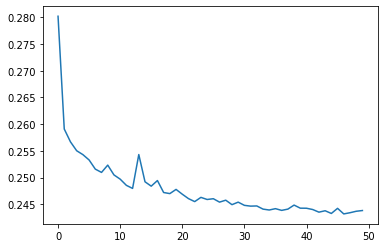

In [ ]:
# plot losses
plt.plot(CLF_model.history['loss'])

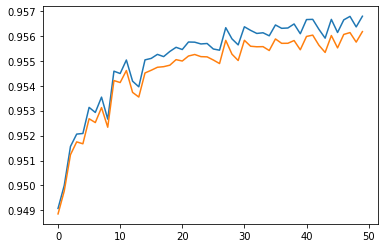

In [ ]:
# plot auc
plt.plot(CLF_model.history['train_auc'])
plt.plot(CLF_model.history['test_auc'])

In [ ]:
# # plot accuracy
# plt.plot(CLF_model.history['train_accuracy'])
# plt.plot(CLF_model.history['test_accuracy'])

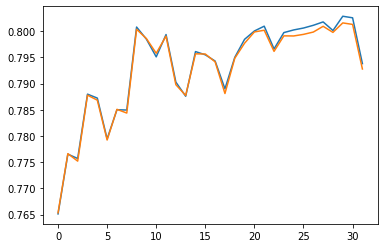

In [ ]:
# plot accuracy
plt.plot(CLF_model.history['train_balanced_accuracy'])
plt.plot(CLF_model.history['test_balanced_accuracy'])

In [ ]:
# # plot learning rates
# plt.plot(CLF_model.history['lr'])

In [ ]:
preds = CLF_model.predict_proba(X_test.values)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test.values.reshape(-1,1))

In [ ]:
print(f"BEST VALID SCORE FOR : {CLF_model.best_cost}")
print(f"FINAL TEST SCORE FOR : {test_auc}")

BEST VALID SCORE FOR : 0.26080710733266393
FINAL TEST SCORE FOR : 0.9558753136508612


In [ ]:
# print('Training accuracy {:.4f}'.format(CLF_model.score(X_train.values,y_train.values.reshape(-1,1))))
# print('Testing accuracy {:.4f}'.format(CLF_model.score(X_test.values,y_test.values.reshape(-1,1))))
print(classification_report(y_test.values.reshape(-1,1),CLF_model.predict(X_test.values)))
# print(plot_confusion_matrix(CLF_model,X_test.values,y_test.values.reshape(-1,1),cmap='Blues_r'))
pd.DataFrame({'Value':CLF_model.feature_importances_,'Feature':X.columns}).sort_values(by="Value",ascending=False).head(15)

              precision    recall  f1-score   support

           0       0.98      0.84      0.90    328976
           1       0.70      0.95      0.81    128874

    accuracy                           0.87    457850
   macro avg       0.84      0.89      0.85    457850
weighted avg       0.90      0.87      0.88    457850



,Value,Feature
1,8.238901e-01,First_item_Unique_id_collection
85,6.247460e-02,pgrank_buyer
81,3.316783e-02,deg_centrality_seller
46,2.340820e-02,Price_USD_median_90d
15,1.772499e-02,BTC_price_60d_rolling_avg
83,1.211007e-02,trans_count_buyer
23,1.110910e-02,MANA_price_14d_rolling_avg
9,4.329250e-03,GoogleTrends_30d_rolling_avg
7,4.084341e-03,GoogleTrends_7d_rolling_avg
11,3.979172e-03,GoogleTrends_90d_rolling_avg


In [ ]:
print(CLF_model.best_cost)

0.26080710733266393


In [ ]:
y_pred = CLF_model.predict(X_test.values)

In [ ]:
def get_model_results2(model, X_train, y_train, X_test, y_test, y_pred):
    # train_acc_score = model.score(X_train, y_train)
    # test_acc_score = model.score(X_test, y_test)
    bal_acc_score = balanced_accuracy_score(y_test, y_pred)
    temp_f1_score = f1_score(y_test, y_pred)
    temp_precision_score = precision_score(y_test, y_pred)
    temp_recall_score = recall_score(y_test, y_pred)
    temp_roc_auc_score = roc_auc_score(y_test, y_pred)
    return bal_acc_score, temp_f1_score, temp_precision_score, temp_recall_score, temp_roc_auc_score

In [ ]:
bal_acc_score, clf_f1_score, clf_precision_score, clf_recall_score, clf_roc_auc_score = get_model_results2(CLF_model, X_train, y_train, X_test, y_test, y_pred)
print("balanced_acc_score: ", bal_acc_score)
print("f1_score: ", clf_f1_score)
print("precision_score: ", clf_precision_score)
print("recall_score: ", clf_recall_score)
print("roc_auc_score: ", clf_roc_auc_score)

balanced_acc_score:  0.8942598563501942
f1_score:  0.8057234985892786
precision_score:  0.7015730000920556
recall_score:  0.9461877492744851
roc_auc_score:  0.8942598563501943


In [ ]:
CLF_cr = classification_report(y_test,y_pred)
print(CLF_cr)

              precision    recall  f1-score   support

           0       0.98      0.84      0.90    328976
           1       0.70      0.95      0.81    128874

    accuracy                           0.87    457850
   macro avg       0.84      0.89      0.85    457850
weighted avg       0.90      0.87      0.88    457850



In [ ]:
pd.DataFrame({'Value':np.squeeze(CLF_model.feature_importances_),'Feature':X.columns}).sort_values(by="Value",ascending=False).head(15)

,Value,Feature
1,8.238901e-01,First_item_Unique_id_collection
85,6.247460e-02,pgrank_buyer
81,3.316783e-02,deg_centrality_seller
46,2.340820e-02,Price_USD_median_90d
15,1.772499e-02,BTC_price_60d_rolling_avg
83,1.211007e-02,trans_count_buyer
23,1.110910e-02,MANA_price_14d_rolling_avg
9,4.329250e-03,GoogleTrends_30d_rolling_avg
7,4.084341e-03,GoogleTrends_7d_rolling_avg
11,3.979172e-03,GoogleTrends_90d_rolling_avg


In [ ]:
write_model_results_3(CLF_model, 'secondary2-49-tabnet-fillcustom-nobal-noscale')
model_results_dict.keys()

dict_keys(['secondary-tabnet-fill0-nobal-noscale', 'secondary-tabnet-fill0-nobal-minmaxscale', 'secondary-tabnet-fillcustom-nobal-noscale', 'secondary-tabnet-fillcustom-nobal-minmaxscale', 'secondary2-49-tabnet-fill0-nobal-noscale', 'secondary2-49-tabnet-fill0-nobal-minmaxscale', 'secondary2-49-tabnet-fillcustom-nobal-noscale'])

In [ ]:
df_model_results = pd.DataFrame(model_results_dict).transpose().reset_index().rename(columns={'index':'unique_model_name'})
print(len(df_model_results))
df_model_results.head()

7


,unique_model_name,model_scope,model_type,balance_method,scale_method,balance_acc_score,f1_score,precision_score,recall_score,roc_auc_score,classification_report,features,coef_values,date_recorded
0,secondary-tabnet-fill0-nobal-noscale,NFT secondary sales,"TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamm...",None,None,0.802719,0.796347,0.781445,0.811828,0.802719,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[0.212438048620167, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",2022-04-08-14:02:12
1,secondary-tabnet-fill0-nobal-minmaxscale,NFT secondary sales,"TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamm...",None,MinMaxScaler,0.781621,0.763385,0.797858,0.731768,0.781621,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[0.16480028167624844, 0.002095364407039438, 0....",2022-04-08-14:39:00
2,secondary-tabnet-fillcustom-nobal-noscale,NFT secondary sales,"TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamm...",None,None,0.799041,0.796655,0.764822,0.831254,0.799041,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[0.13950349445035315, 0.010005813196791297, 0....",2022-04-08-15:39:58
3,secondary-tabnet-fillcustom-nobal-minmaxscale,NFT secondary sales,"TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamm...",None,MinMaxScaler,0.802552,0.802931,0.758351,0.85308,0.802552,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[0.09678208083604772, 0.07243406087793339, 3.3...",2022-04-08-17:44:21
4,secondary2-49-tabnet-fill0-nobal-noscale,NFT sales 2-49,"TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamm...",None,None,0.886272,0.790118,0.675588,0.951406,0.886272,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[6.883974770867169e-06, 0.3785931395110315, 0....",2022-04-08-22:35:07


In [ ]:
df_model_results.to_pickle('/content/drive/My Drive/df_model_results_tabnet.pkl')

TabNet - FillNA=Custom, Unbalanced, Scaled

In [16]:
# model characteristics to record with results
model_scope = 'NFT sales 2-49'
# model_type = use CLF_model
fillna_method = 'Fill NaNs with custom method'
balance_method = 'None'
scale_method = 'MinMaxScaler'

In [17]:
X, y, indices = get_x_and_y(df_collection_nft_second_2_50, 1)
print(len(X), len(y), len(indices))

2289248 2289248 2289248


In [18]:
X_train, X_test, y_train, y_test, indices_train, indices_test = get_scaled_train_test_splits(X, y, indices)
print(len(X_train), len(X_test), len(y_train), len(y_test), len(indices_train), len(indices_test))

1831398 457850 1831398 457850 1831398 457850


In [19]:
tabnet_params = {"optimizer_fn":torch.optim.Adam,
                 "optimizer_params":dict(lr=2e-2),
                 "scheduler_params":{"step_size":50, # how to use learning rate scheduler
                                 "gamma":0.9},
                 "scheduler_fn":torch.optim.lr_scheduler.StepLR,
                 "mask_type":'entmax' # "sparsemax"
                }

CLF_model = TabNetClassifier(**tabnet_params
                      )

Device used : cuda


In [20]:
max_epochs = 50 if not os.getenv("CI", False) else 2

In [21]:
# This illustrates the warm_start=False behaviour
save_history = []
for _ in range(2):
    CLF_model.fit(
        X_train=X_train, y_train=y_train.values,
        eval_set=[(X_train, y_train.values), (X_test, y_test.values)],
        eval_name=['train', 'test'],
        eval_metric=['accuracy', 'balanced_accuracy', 'auc', 'logloss'],
        max_epochs=max_epochs , patience=20,
        batch_size=1024, virtual_batch_size=128,
        num_workers=0,
        weights=1,
        drop_last=False,
        #augmentations=aug, #aug, None
    )
    save_history.append(CLF_model.history["test_accuracy", "test_bal_accuracy", "test_auc", "test_logloss"])

assert(np.all(np.array(save_history[0]==np.array(save_history[1]))))

epoch 0  | loss: 0.27645 | train_accuracy: 0.85577 | train_balanced_accuracy: 0.88764 | train_auc: 0.94412 | train_logloss: 0.32249 | test_accuracy: 0.85541 | test_balanced_accuracy: 0.88724 | test_auc: 0.94424 | test_logloss: 0.3222  |  0:02:50s
epoch 1  | loss: 0.25854 | train_accuracy: 0.86777 | train_balanced_accuracy: 0.89164 | train_auc: 0.95155 | train_logloss: 0.27422 | test_accuracy: 0.86738 | test_balanced_accuracy: 0.89148 | test_auc: 0.95103 | test_logloss: 0.27603 |  0:05:40s
epoch 2  | loss: 0.25589 | train_accuracy: 0.85948 | train_balanced_accuracy: 0.88973 | train_auc: 0.95231 | train_logloss: 0.2763  | test_accuracy: 0.85894 | test_balanced_accuracy: 0.88913 | test_auc: 0.95184 | test_logloss: 0.27768 |  0:08:33s
epoch 3  | loss: 0.25348 | train_accuracy: 0.86474 | train_balanced_accuracy: 0.89213 | train_auc: 0.95321 | train_logloss: 0.27607 | test_accuracy: 0.86457 | test_balanced_accuracy: 0.89194 | test_auc: 0.95279 | test_logloss: 0.27711 |  0:11:25s
epoch 4  | l

KeyError: ignored

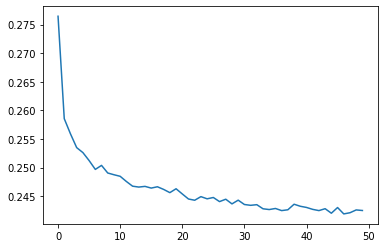

In [22]:
# plot losses
plt.plot(CLF_model.history['loss'])

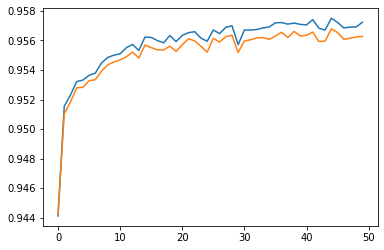

In [23]:
# plot auc
plt.plot(CLF_model.history['train_auc'])
plt.plot(CLF_model.history['test_auc'])

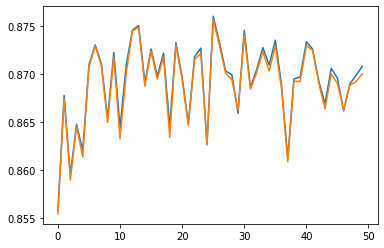

In [24]:
# plot accuracy
plt.plot(CLF_model.history['train_accuracy'])
plt.plot(CLF_model.history['test_accuracy'])

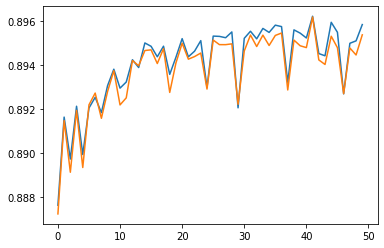

In [25]:
# plot accuracy
plt.plot(CLF_model.history['train_balanced_accuracy'])
plt.plot(CLF_model.history['test_balanced_accuracy'])

In [26]:
# # plot learning rates
# plt.plot(CLF_model.history['lr'])

In [27]:
preds = CLF_model.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test.values.reshape(-1,1))

In [28]:
print(f"BEST VALID SCORE FOR : {CLF_model.best_cost}")
print(f"FINAL TEST SCORE FOR : {test_auc}")

BEST VALID SCORE FOR : 0.25595074502827964
FINAL TEST SCORE FOR : 0.956293825795968


In [29]:
# print('Training accuracy {:.4f}'.format(CLF_model.score(X_train.values,y_train.values.reshape(-1,1))))
# print('Testing accuracy {:.4f}'.format(CLF_model.score(X_test.values,y_test.values.reshape(-1,1))))
print(classification_report(y_test.values.reshape(-1,1),CLF_model.predict(X_test)))
# print(plot_confusion_matrix(CLF_model,X_test,y_test.values.reshape(-1,1),cmap='Blues_r'))
pd.DataFrame({'Value':CLF_model.feature_importances_,'Feature':X.columns}).sort_values(by="Value",ascending=False).head(15)

              precision    recall  f1-score   support

           0       0.98      0.84      0.91    328976
           1       0.70      0.95      0.81    128874

    accuracy                           0.87    457850
   macro avg       0.84      0.90      0.86    457850
weighted avg       0.90      0.87      0.88    457850



,Value,Feature
1,5.611928e-01,First_item_Unique_id_collection
12,1.970437e-01,BTC_price_7d_rolling_avg
81,1.624735e-01,deg_centrality_seller
25,2.517739e-02,MANA_price_60d_rolling_avg
82,1.664345e-02,pgrank_seller
56,9.909688e-03,Price_Crypto_median_14d
74,8.212476e-03,p_resale
83,4.541297e-03,trans_count_buyer
64,4.502881e-03,Price_Crypto_median_180d
2,4.005926e-03,GoogleTrends


In [30]:
print(CLF_model.best_cost)

0.25595074502827964


In [31]:
y_pred = CLF_model.predict(X_test)

In [32]:
bal_acc_score, clf_f1_score, clf_precision_score, clf_recall_score, clf_roc_auc_score = get_model_results2(CLF_model, X_train, y_train, X_test, y_test, y_pred)
print("balanced_acc_score: ", bal_acc_score)
print("f1_score: ", clf_f1_score)
print("precision_score: ", clf_precision_score)
print("recall_score: ", clf_recall_score)
print("roc_auc_score: ", clf_roc_auc_score)

balanced_acc_score:  0.895343646731762
f1_score:  0.807485197406526
precision_score:  0.7040382295736687
recall_score:  0.9465679656098205
roc_auc_score:  0.895343646731762


In [33]:
CLF_cr = classification_report(y_test,y_pred)
print(CLF_cr)

              precision    recall  f1-score   support

           0       0.98      0.84      0.91    328976
           1       0.70      0.95      0.81    128874

    accuracy                           0.87    457850
   macro avg       0.84      0.90      0.86    457850
weighted avg       0.90      0.87      0.88    457850



In [34]:
pd.DataFrame({'Value':np.squeeze(CLF_model.feature_importances_),'Feature':X.columns}).sort_values(by="Value",ascending=False).head(15)

,Value,Feature
1,5.611928e-01,First_item_Unique_id_collection
12,1.970437e-01,BTC_price_7d_rolling_avg
81,1.624735e-01,deg_centrality_seller
25,2.517739e-02,MANA_price_60d_rolling_avg
82,1.664345e-02,pgrank_seller
56,9.909688e-03,Price_Crypto_median_14d
74,8.212476e-03,p_resale
83,4.541297e-03,trans_count_buyer
64,4.502881e-03,Price_Crypto_median_180d
2,4.005926e-03,GoogleTrends


In [35]:
write_model_results_3(CLF_model, 'secondary2-49-tabnet-fillcustom-nobal-minmaxscale')
model_results_dict.keys()

dict_keys(['secondary-tabnet-fill0-nobal-noscale', 'secondary-tabnet-fill0-nobal-minmaxscale', 'secondary-tabnet-fillcustom-nobal-noscale', 'secondary-tabnet-fillcustom-nobal-minmaxscale', 'secondary2-49-tabnet-fill0-nobal-noscale', 'secondary2-49-tabnet-fill0-nobal-minmaxscale', 'secondary2-49-tabnet-fillcustom-nobal-noscale', 'secondary2-49-tabnet-fillcustom-nobal-minmaxscale'])

In [36]:
df_model_results = pd.DataFrame(model_results_dict).transpose().reset_index().rename(columns={'index':'unique_model_name'})
print(len(df_model_results))
df_model_results.head()

8


,unique_model_name,model_scope,model_type,balance_method,scale_method,balance_acc_score,f1_score,precision_score,recall_score,roc_auc_score,classification_report,features,coef_values,date_recorded
0,secondary-tabnet-fill0-nobal-noscale,NFT secondary sales,"TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamm...",None,None,0.802719,0.796347,0.781445,0.811828,0.802719,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[0.212438048620167, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",2022-04-08-14:02:12
1,secondary-tabnet-fill0-nobal-minmaxscale,NFT secondary sales,"TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamm...",None,MinMaxScaler,0.781621,0.763385,0.797858,0.731768,0.781621,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[0.16480028167624844, 0.002095364407039438, 0....",2022-04-08-14:39:00
2,secondary-tabnet-fillcustom-nobal-noscale,NFT secondary sales,"TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamm...",None,None,0.799041,0.796655,0.764822,0.831254,0.799041,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[0.13950349445035315, 0.010005813196791297, 0....",2022-04-08-15:39:58
3,secondary-tabnet-fillcustom-nobal-minmaxscale,NFT secondary sales,"TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamm...",None,MinMaxScaler,0.802552,0.802931,0.758351,0.85308,0.802552,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[0.09678208083604772, 0.07243406087793339, 3.3...",2022-04-08-17:44:21
4,secondary2-49-tabnet-fill0-nobal-noscale,NFT sales 2-49,"TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamm...",None,None,0.886272,0.790118,0.675588,0.951406,0.886272,precision recall f1-score ...,"Index(['nft_sales_count', 'First_item_Unique_i...","[6.883974770867169e-06, 0.3785931395110315, 0....",2022-04-08-22:35:07


In [37]:
df_model_results.to_pickle('/content/drive/My Drive/df_model_results_tabnet.pkl')

In [38]:
model_results_dict.keys()

dict_keys(['secondary-tabnet-fill0-nobal-noscale', 'secondary-tabnet-fill0-nobal-minmaxscale', 'secondary-tabnet-fillcustom-nobal-noscale', 'secondary-tabnet-fillcustom-nobal-minmaxscale', 'secondary2-49-tabnet-fill0-nobal-noscale', 'secondary2-49-tabnet-fill0-nobal-minmaxscale', 'secondary2-49-tabnet-fillcustom-nobal-noscale', 'secondary2-49-tabnet-fillcustom-nobal-minmaxscale'])